In [43]:
import numpy as np
import scanpy as sc
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import pandas as pd
import scipy
import random

from feature_selection import feature_selection, HDA, epiScanpy, Signac

In [2]:
def plot_heatmap(X, y, classes=None, y_pred=None, row_labels=None, colormap=None, row_cluster=False,
                 cax_title='', xlabel='', ylabel='', yticklabels='', legend_font=10, 
                 show_legend=True, show_cax=True, tick_color='black', ncol=3,
                 bbox_to_anchor=(0.5, 1.3), position=(0.8, 0.78, .1, .04), return_grid=False,
                 save=None, **kw):
    """
    plot hidden code heatmap with labels

    Params:
        X: fxn array, n is sample number, f is feature
        y: a array of labels for n elements or a list of array
    """

    import matplotlib.patches as mpatches  # add legend
    # if classes is not None:
    X, y, classes, index = sort_by_classes(X, y, classes)
    # else:
        # classes = np.unique(y)

    if y_pred != None:
        y_pred = y_pred[index]
        classes = list(classes) + list(np.unique(y_pred)) 
        if colormap is None:
            colormap = plt.cm.tab20
            colors = {c:colormap(i) for i, c in enumerate(classes)}
        else:
            colors = {c:colormap[i] for i, c in enumerate(classes)}
        col_colors = []
        col_colors.append([colors[c] for c in y])
        col_colors.append([colors[c] for c in y_pred])
    else:
        if colormap is None:
            colormap = plt.cm.tab20
            colors = {c:colormap(i) for i, c in enumerate(classes)}
        else:
            colors = {c:colormap[i] for i, c in enumerate(classes)}
        col_colors = [ colors[c] for c in y ]
        
    legend_TN = [mpatches.Patch(color=color, label=c) for c, color in colors.items()]

    if row_labels != None:
        row_colors = [ colors[c] for c in row_labels ]
        kw.update({'row_colors':row_colors})

    kw.update({'col_colors':col_colors})

    cbar_kws={"orientation": "horizontal"}
    grid = sns.clustermap(X, yticklabels=True, 
            col_cluster=False,
            row_cluster=row_cluster,
            cbar_kws=cbar_kws, **kw)
    if show_cax:
        grid.cax.set_position(position)
        grid.cax.tick_params(length=1, labelsize=4, rotation=0)
        grid.cax.set_title(cax_title, fontsize=6, y=0.35)

    if show_legend:
        grid.ax_heatmap.legend(loc='upper center', 
                               bbox_to_anchor=bbox_to_anchor, 
                               handles=legend_TN, 
                               fontsize=legend_font, 
                               frameon=False, 
                               ncol=ncol)
        grid.ax_col_colors.tick_params(labelsize=6, length=0, labelcolor='orange')
 
    if (row_cluster==True) and (yticklabels != ''):
        yticklabels = yticklabels[grid.dendrogram_row.reordered_ind]

    grid.ax_heatmap.set_xlabel(xlabel)
    grid.ax_heatmap.set_ylabel(ylabel, fontsize=8)
    grid.ax_heatmap.set_xticklabels('')
    grid.ax_heatmap.set_yticklabels(yticklabels, color=tick_color)
    grid.ax_heatmap.yaxis.set_label_position('left')
    grid.ax_heatmap.tick_params(axis='x', length=0)
    grid.ax_heatmap.tick_params(axis='y', labelsize=6, length=0, rotation=0, labelleft=True, labelright=False)
    grid.ax_row_dendrogram.set_visible(False)
    grid.cax.set_visible(show_cax)
    grid.row_color_labels = classes

    if save:
        plt.savefig(save, format='pdf', bbox_inches='tight')
    else:
        plt.show()
    if return_grid:
        return grid
def sort_by_classes(X, y, classes):
    if classes is None:
        classes = np.unique(y)
    index = []
    #print(classes)
    #print(y)
    for c in classes:
        #print(np.where(y==c))
        ind = np.where(y==c)[0]
        #print(ind)
        index.append(ind)
    index = np.concatenate(index)
    #print(index)
    X = X[:,index]
    y = y[index]
    return X, y, classes, index

In [3]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
sns.set_theme(style='whitegrid',font_scale=2)

# Dataset S1

In [5]:
random.seed(2000)
np.random.seed(2000)
peak_num = 100000
cell_num = 2000
ATAC_matrix = np.array(np.random.rand(cell_num,peak_num) > 0.95,dtype='float')
for idx in range(5000):
    open_degree = random.uniform(0.05, 0.1)
    ATAC_matrix[:1000, idx] = np.array(np.random.rand(1000) > 1 - open_degree,dtype='float')
    ATAC_matrix[-1000:, idx] = np.array(np.random.rand(1000) > 1 - (0.1 - open_degree),dtype='float')
for idx in range(5000,10000):
    open_degree = random.uniform(0, 0.05)
    ATAC_matrix[:1000, idx] = np.array(np.random.rand(1000) > 1 - open_degree,dtype='float')
    ATAC_matrix[-1000:, idx] = np.array(np.random.rand(1000) > 1 - (0.1 - open_degree),dtype='float')
label = ['cell type A'] * 1000 + ['cell type B'] * 1000
label1 = label
ATAC_matrix1 = np.copy(ATAC_matrix)
ATAC_matrix1.shape

(2000, 100000)

## Matrix

In [6]:
idx = random.sample(list(np.arange(5000)), 200)
idx = idx+(np.array(idx)+5000).tolist()+(np.array(idx)+10000).tolist()
idx = np.sort(idx)
idy = random.sample(list(np.arange(1000)), 200)
idy = idy+(np.array(idy)+1000).tolist()
idy = np.sort(idy)
ATAC_matrix_new = ATAC_matrix[:,idx][idy,:]
ATAC_matrix_new.shape
label_new = np.array(label)[idy]

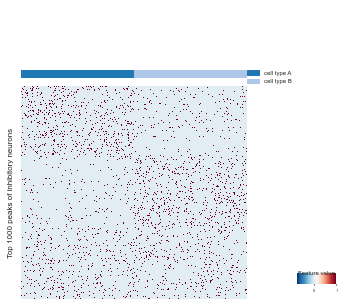

In [8]:
plot_heatmap(ATAC_matrix_new.T, np.array(label_new), vmin=-0.8, vmax=1, figsize=(5, 5), legend_font=6, cmap='RdBu_r', 
             bbox_to_anchor=(1.1, 1.1), position=(0.98, 0.2, .11, .03), ncol=1, 
              row_cluster=False, ylabel='Top 1000 peaks of inhibitory neurons', cax_title='Feature value')

## UMAP

In [9]:
def tfidf2(count_mat): 
    tf_mat = 1.0 * count_mat / np.tile(np.sum(count_mat,axis=0), (count_mat.shape[0],1))
    signac_mat = np.log(1 + np.multiply(1e4*tf_mat,  np.tile((1.0 * count_mat.shape[1] / np.sum(count_mat,axis=1)).reshape(-1,1), (1,count_mat.shape[1]))))
#     return scipy.sparse.csr_matrix(signac_mat)
    return signac_mat

After PCA, the matrix dimensions are reduced to (2000, 10)
0       cell type A
1       cell type A
2       cell type A
3       cell type A
4       cell type A
           ...     
1995    cell type B
1996    cell type B
1997    cell type B
1998    cell type B
1999    cell type B
Name: label, Length: 2000, dtype: object


<function matplotlib.pyplot.show(close=None, block=None)>

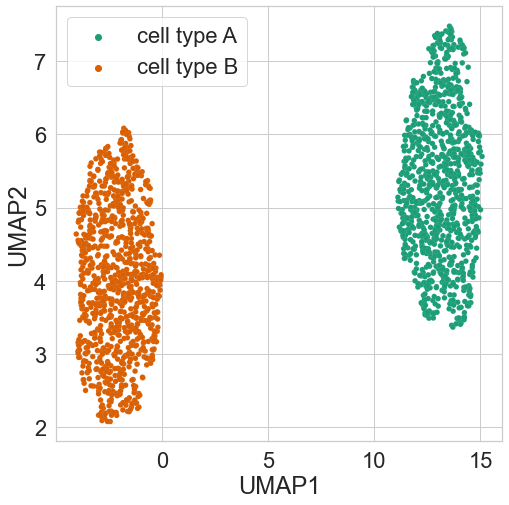

In [12]:
seed_base = 2
ATAC_count = tfidf2(ATAC_matrix1.T).T
ATAC_count_filter = ATAC_count
ATAC_count_filter = PCA(n_components=10,random_state=int(seed_base*1000)).fit_transform(ATAC_count_filter)
print('After PCA, the matrix dimensions are reduced to {}'.format(ATAC_count_filter.shape))
ATAC_pca = sc.AnnData(scipy.sparse.csc_matrix(ATAC_count_filter),dtype = 'float32')
ATAC_pca.obs['label'] = label1
print(ATAC_pca.obs['label'])

# umap
label = ATAC_pca.obs['label']
proj = umap.UMAP(random_state=int(seed_base*1000)).fit_transform(ATAC_count_filter)
fig = plt.figure()
fig.set_figwidth(8)
fig.set_figheight(8)
df = {'UMAP1':proj[:, 0],\
    'UMAP2':proj[:, 1], \
    'label':label}
df = pd.DataFrame(df)
ax = sns.scatterplot(x="UMAP1", y="UMAP2", hue="label",palette = 'Dark2', s=30,linewidth = 0.05, data=df)
ax.legend()
# plt.savefig('sim1UMAP.pdf', dpi=500)
plt.show

# Dataset S2

In [13]:
random.seed(2000)
np.random.seed(2000)

peak_num = 100000
cell_num = 2000
ATAC_matrix = np.zeros((cell_num, peak_num))
for idx in range(peak_num):
    open_degree = random.uniform(0, 0.05)
    ATAC_matrix[:, idx] = np.array(np.random.rand(2000) > 1 - open_degree,dtype='float')
for idx in range(5000):
    open_degree = random.uniform(0, 0.075)
    ATAC_matrix[:1000, idx] = np.array(np.random.rand(1000) > 1 - open_degree,dtype='float')
    ATAC_matrix[-1000:, idx] = np.array(np.random.rand(1000) > 1 - open_degree/3,dtype='float')
for idx in range(5000,10000):
    open_degree = random.uniform(0, 0.025)
    ATAC_matrix[:1000, idx] = np.array(np.random.rand(1000) > 1 - open_degree,dtype='float')
    ATAC_matrix[-1000:, idx] = np.array(np.random.rand(1000) > 1 - open_degree*3,dtype='float')
ATAC_matrix = ATAC_matrix[:,np.sum(ATAC_matrix,axis=0)>0]
label = ['cell type A'] * 1000 + ['cell type B'] * 1000
label2 = label
ATAC_matrix2 = np.copy(ATAC_matrix)
ATAC_matrix2.shape

(2000, 99002)

## Matrix

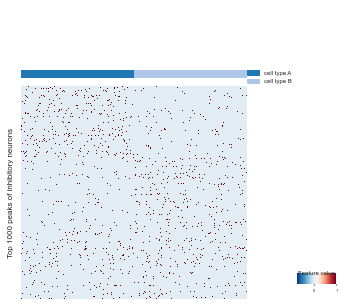

In [14]:
idx = random.sample(list(np.arange(5000)), 200)
idx = idx+(np.array(idx)+5000).tolist()+(np.array(idx)+10000).tolist()
idx = np.sort(idx)
idy = random.sample(list(np.arange(1000)), 200)
idy = idy+(np.array(idy)+1000).tolist()
idy = np.sort(idy)
ATAC_matrix_new = ATAC_matrix[:,idx][idy,:]
ATAC_matrix_new.shape
label_new = np.array(label)[idy]
plot_heatmap(ATAC_matrix_new.T, np.array(label_new), vmin=-0.8, vmax=1, figsize=(5, 5), legend_font=6, cmap='RdBu_r', 
             bbox_to_anchor=(1.1, 1.1), position=(0.98, 0.2, .11, .03), ncol=1, 
              row_cluster=False, ylabel='Top 1000 peaks of inhibitory neurons', cax_title='Feature value')

## UMAP

选择peak后矩阵维度为(2000, 99002)
pca后矩阵维度为(2000, 10)
0       cell type A
1       cell type A
2       cell type A
3       cell type A
4       cell type A
           ...     
1995    cell type B
1996    cell type B
1997    cell type B
1998    cell type B
1999    cell type B
Name: label, Length: 2000, dtype: object


<function matplotlib.pyplot.show(close=None, block=None)>

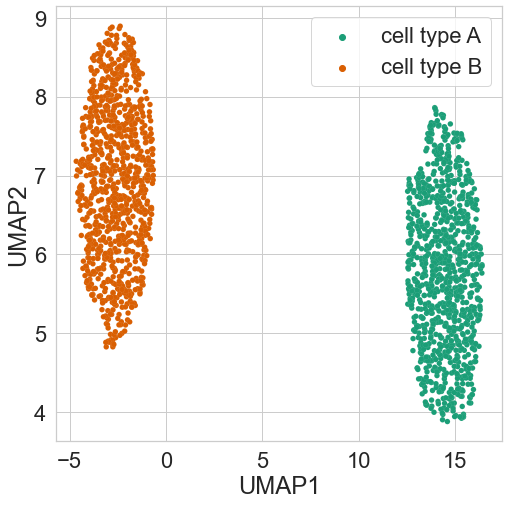

In [15]:
seed_base = 2
ATAC_count = tfidf2(ATAC_matrix2.T).T
ATAC_count_filter = ATAC_count
ATAC_count_filter = PCA(n_components=10,random_state=int(seed_base*1000)).fit_transform(ATAC_count_filter)
print('After PCA, the matrix dimensions are reduced to {}'.format(ATAC_count_filter.shape))
ATAC_pca = sc.AnnData(scipy.sparse.csc_matrix(ATAC_count_filter),dtype = 'float32')
ATAC_pca.obs['label'] = label2
print(ATAC_pca.obs['label'])

# umap
label = ATAC_pca.obs['label']
proj = umap.UMAP(random_state=int(seed_base*1000)).fit_transform(ATAC_count_filter)
fig = plt.figure()
fig.set_figwidth(8)
fig.set_figheight(8)
df = {'UMAP1':proj[:, 0],\
    'UMAP2':proj[:, 1], \
    'label':label}
df = pd.DataFrame(df)
ax = sns.scatterplot(x="UMAP1", y="UMAP2", hue="label",palette = 'Dark2', s=30,linewidth = 0.05, data=df)
# plt.savefig('sim2UMAP.pdf', dpi=500)
ax.legend()
plt.show

# Dateset S3

In [16]:
random.seed(2000)
np.random.seed(2000)

peak_num = 100000
cell_num = 3000
ATAC_matrix = np.zeros((cell_num, peak_num))
for idx in range(peak_num):
    open_degree = random.uniform(0, 0.05)
    ATAC_matrix[:, idx] = np.array(np.random.rand(3000) > 1 - open_degree,dtype='float')
for idx in range(5000):
    open_degree = random.uniform(0.05, 0.1)
    ATAC_matrix[:1500, idx] = np.array(np.random.rand(1500) > 1 - open_degree,dtype='float')
    ATAC_matrix[-(3000-1500):, idx] = np.array(np.random.rand(1500) > 1 - (0.05 - open_degree/2.5),dtype='float')
for idx in range(5000,10000):
    open_degree = random.uniform(0.05, 0.1)
    ATAC_matrix[1500:2250, idx] = np.array(np.random.rand(750) > 1 - open_degree,dtype='float')
    ATAC_matrix[:1500, idx] = np.array(np.random.rand(1500) > 1 - (0.05 - open_degree/2.5),dtype='float')
    ATAC_matrix[-(3000-2250):, idx] = np.array(np.random.rand(750) > 1 - (0.05 - open_degree/2.5),dtype='float')
for idx in range(10000,15000):
    open_degree = random.uniform(0.05, 0.1)
    ATAC_matrix[2250:3000, idx] = np.array(np.random.rand(750) > 1 - open_degree,dtype='float')
    ATAC_matrix[:2250, idx] = np.array(np.random.rand(2250) > 1 - (0.05 - open_degree/2.5),dtype='float')
ATAC_matrix = ATAC_matrix[:,np.sum(ATAC_matrix,axis=0)>0]

label = ['cell type A'] * 1500 + ['cell type B'] * 750 + ['cell type C'] * 750
label3 = label
ATAC_matrix3 = np.copy(ATAC_matrix)
ATAC_matrix3.shape

(3000, 99404)

## Matrix

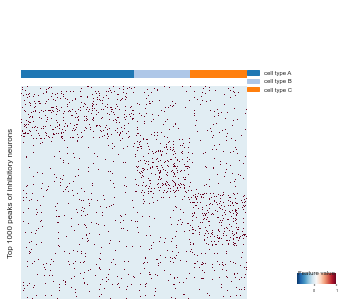

In [17]:
idx = random.sample(list(np.arange(5000)), 200)
idx = idx+(np.array(idx)+5000).tolist()+(np.array(idx)+10000).tolist()+(np.array(idx)+15000).tolist()
idx = np.sort(idx)
idy = random.sample(list(np.arange(750)), 150)
idy = idy+(np.array(idy)+750).tolist()+(np.array(idy)+1500).tolist()+(np.array(idy)+2250).tolist()
idy = np.sort(idy)
ATAC_matrix_new = ATAC_matrix[:,idx][idy,:]
ATAC_matrix_new.shape
label_new = np.array(label)[idy]
plot_heatmap(ATAC_matrix_new.T, np.array(label_new), vmin=-0.8, vmax=1, figsize=(5, 5), legend_font=6, cmap='RdBu_r', 
             bbox_to_anchor=(1.1, 1.1), position=(0.98, 0.2, .11, .03), ncol=1, 
              row_cluster=False, ylabel='Top 1000 peaks of inhibitory neurons', cax_title='Feature value')

## UMAP

选择peak后矩阵维度为(3000, 99404)
pca后矩阵维度为(3000, 10)
0       cell type A
1       cell type A
2       cell type A
3       cell type A
4       cell type A
           ...     
2995    cell type C
2996    cell type C
2997    cell type C
2998    cell type C
2999    cell type C
Name: label, Length: 3000, dtype: object


<function matplotlib.pyplot.show(close=None, block=None)>

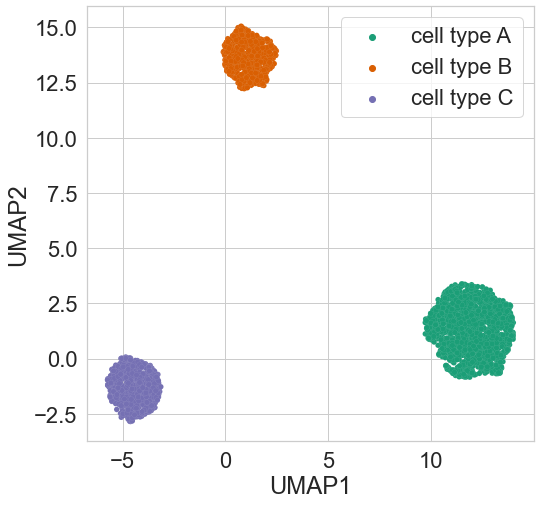

In [18]:
seed_base = 2
ATAC_count = tfidf2(ATAC_matrix3.T).T
ATAC_count_filter = ATAC_count
ATAC_count_filter = PCA(n_components=10,random_state=int(seed_base*1000)).fit_transform(ATAC_count_filter)
print('After PCA, the matrix dimensions are reduced to {}'.format(ATAC_count_filter.shape))
ATAC_pca = sc.AnnData(scipy.sparse.csc_matrix(ATAC_count_filter),dtype = 'float32')
ATAC_pca.obs['label'] = label3
print(ATAC_pca.obs['label'])

# umap
label = ATAC_pca.obs['label']
proj = umap.UMAP(random_state=int(seed_base*1000)).fit_transform(ATAC_count_filter)
fig = plt.figure()
fig.set_figwidth(8)
fig.set_figheight(8)
df = {'UMAP1':proj[:, 0],\
    'UMAP2':proj[:, 1], \
    'label':label}
df = pd.DataFrame(df)
ax = sns.scatterplot(x="UMAP1", y="UMAP2", hue="label",palette = 'Dark2', s=30,linewidth = 0.05, data=df)
# plt.savefig('sim3UMAP.pdf', dpi=500)
ax.legend()
plt.show

# Dataset S4

In [20]:
random.seed(2000)
np.random.seed(2000)

peak_num = 100000
cell_num = 4000
ATAC_matrix = np.zeros((cell_num, peak_num))
for idx in range(peak_num):
    open_degree = random.uniform(0, 0.05)
    ATAC_matrix[:, idx] = np.array(np.random.rand(4000) > 1 - open_degree,dtype='float')
for idx in range(5000):
    open_degree = random.uniform(0.05, 0.1)
    ATAC_matrix[:1200, idx] = np.array(np.random.rand(1200) > 1 - open_degree,dtype='float')
    ATAC_matrix[-(4000-1200):, idx] = np.array(np.random.rand(2800) > 1 - (0.05 - open_degree/2.5),dtype='float')
for idx in range(5000,10000):
    open_degree = random.uniform(0.05, 0.1)
    ATAC_matrix[1200:2400, idx] = np.array(np.random.rand(1200) > 1 - open_degree,dtype='float')
    ATAC_matrix[:1200, idx] = np.array(np.random.rand(1200) > 1 - (0.05 - open_degree/2.5),dtype='float')
    ATAC_matrix[-(4000-2400):, idx] = np.array(np.random.rand(1600) > 1 - (0.05 - open_degree/2.5),dtype='float')
for idx in range(10000,15000):
    open_degree = random.uniform(0.05, 0.1)
    ATAC_matrix[2400:3600, idx] = np.array(np.random.rand(1200) > 1 - open_degree,dtype='float')
    ATAC_matrix[:2400, idx] = np.array(np.random.rand(2400) > 1 - (0.05 - open_degree/2.5),dtype='float')
    ATAC_matrix[-(4000-3600):, idx] = np.array(np.random.rand(400) > 1 - (0.05 - open_degree/2.5),dtype='float')
for idx in range(15000,20000):
    open_degree = random.uniform(0.05, 0.1)
    ATAC_matrix[3600:4000, idx] = np.array(np.random.rand(400) > 1 - open_degree,dtype='float')
    ATAC_matrix[:3600, idx] = np.array(np.random.rand(3600) > 1 - (0.05 - open_degree/2.5),dtype='float')
ATAC_matrix = ATAC_matrix[:,np.sum(ATAC_matrix,axis=0)>0]

label = ['cell type A'] * 1200 + ['cell type B'] * 1200 + ['cell type C'] * 1200 + ['cell type D'] * 400
label4 = label
ATAC_matrix4 = np.copy(ATAC_matrix)
ATAC_matrix4.shape

(4000, 99580)

## Matrix

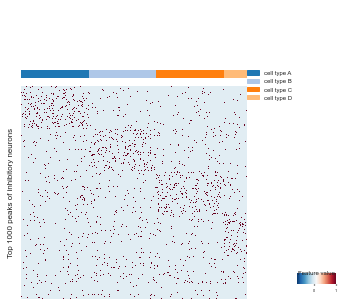

In [21]:
idx = random.sample(list(np.arange(5000)), 200)
idx = idx+(np.array(idx)+5000).tolist()+(np.array(idx)+10000).tolist()+(np.array(idx)+15000).tolist()+(np.array(idx)+20000).tolist()
idx = np.sort(idx)
idy = random.sample(list(np.arange(1200)), 240)
idy = idy+(np.array(idy)+1200).tolist()+(np.array(idy)+2400).tolist()+random.sample(list(np.arange(400)+3600), 80)
idy = np.sort(idy)
ATAC_matrix_new = ATAC_matrix[:,idx][idy,:]
ATAC_matrix_new.shape
label_new = np.array(label)[idy]
plot_heatmap(ATAC_matrix_new.T, np.array(label_new), vmin=-0.8, vmax=1, figsize=(5, 5), legend_font=6, cmap='RdBu_r', 
             bbox_to_anchor=(1.1, 1.1), position=(0.98, 0.2, .11, .03), ncol=1, 
              row_cluster=False, ylabel='Top 1000 peaks of inhibitory neurons', cax_title='Feature value')

## UMAP

选择peak后矩阵维度为(4000, 99580)
pca后矩阵维度为(4000, 10)
0       cell type A
1       cell type A
2       cell type A
3       cell type A
4       cell type A
           ...     
3995    cell type D
3996    cell type D
3997    cell type D
3998    cell type D
3999    cell type D
Name: label, Length: 4000, dtype: object


<function matplotlib.pyplot.show(close=None, block=None)>

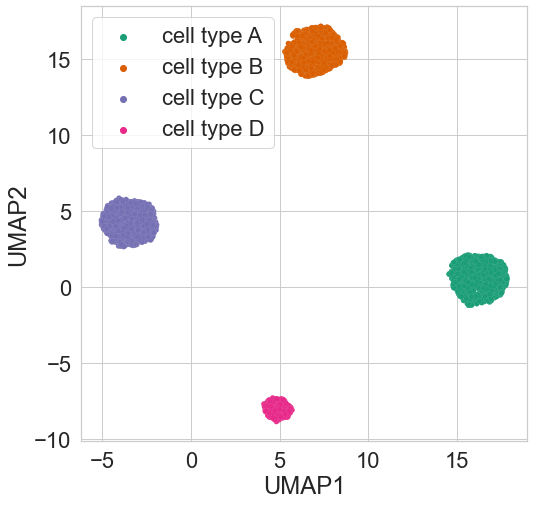

In [22]:
seed_base = 2
ATAC_count = tfidf2(ATAC_matrix4.T).T
ATAC_count_filter = ATAC_count
ATAC_count_filter = PCA(n_components=10,random_state=int(seed_base*1000)).fit_transform(ATAC_count_filter)
print('After PCA, the matrix dimensions are reduced to {}'.format(ATAC_count_filter.shape))
ATAC_pca = sc.AnnData(scipy.sparse.csc_matrix(ATAC_count_filter),dtype = 'float32')
ATAC_pca.obs['label'] = label4
print(ATAC_pca.obs['label'])

# umap
label = ATAC_pca.obs['label']
proj = umap.UMAP(random_state=int(seed_base*1000)).fit_transform(ATAC_count_filter)
fig = plt.figure()
fig.set_figwidth(8)
fig.set_figheight(8)
df = {'UMAP1':proj[:, 0],\
    'UMAP2':proj[:, 1], \
    'label':label}
df = pd.DataFrame(df)
ax = sns.scatterplot(x="UMAP1", y="UMAP2", hue="label",palette = 'Dark2', s=30,linewidth = 0.05, data=df)
# plt.savefig('sim4UMAP.pdf', bbox_inches ="tight", dpi=500)
ax.legend()
plt.show

# Dataset S5

In [23]:
random.seed(2000)
np.random.seed(2000)

peak_num = 100000
cell_num = 750
ATAC_matrix = np.zeros((cell_num, peak_num))
offset = np.random.normal(loc=0.0,scale=0.01,size=(750,100000))
for idx in range(100000):
    if idx % 5000 == 0:
        print('processing...{}%/100%'.format((idx / 100000)*100))
    for cell in range(750):
        if cell == 0:
            open_degree = 0.05
        elif cell == 500:
            open_degree = open_degree_keep + offset[cell,idx]
        else:
            open_degree = open_degree_old + offset[cell,idx]
        if open_degree < 0:
            open_degree = 0
        elif open_degree > 0.2:
            open_degree = 0.2
        ATAC_matrix[cell, idx] = np.array(np.random.rand(1) > 1 - open_degree,dtype='float')
        open_degree_old = open_degree
        if cell == 249:
            open_degree_keep = open_degree
for idx in range(10000,peak_num):
    random.shuffle(ATAC_matrix[:,idx])
ATAC_matrix = ATAC_matrix[:,np.sum(ATAC_matrix,axis=0)>0]

label = ['cell type A'] * 250 + ['cell type B'] * 250 + ['cell type C'] * 250
label5 = label
ATAC_matrix5 = np.copy(ATAC_matrix)
ATAC_matrix5.shape

processing...0.0%/100%
processing...5.0%/100%
processing...10.0%/100%
processing...15.0%/100%
processing...20.0%/100%
processing...25.0%/100%
processing...30.0%/100%
processing...35.0%/100%
processing...40.0%/100%
processing...45.0%/100%
processing...50.0%/100%
processing...55.00000000000001%/100%
processing...60.0%/100%
processing...65.0%/100%
processing...70.0%/100%
processing...75.0%/100%
processing...80.0%/100%
processing...85.0%/100%
processing...90.0%/100%
processing...95.0%/100%


(750, 100000)

## Matrix

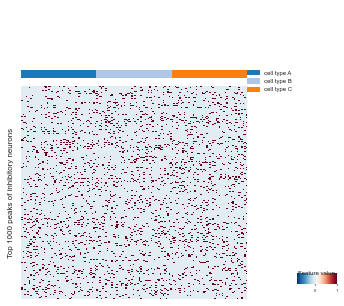

In [24]:
idx = random.sample(list(np.arange(10000)), 200)
idx = idx+(np.array(idx)+10000).tolist()
idx = np.sort(idx)
idy = random.sample(list(np.arange(250)), 50)
idy = idy+(np.array(idy)+250).tolist()+(np.array(idy)+500).tolist()
idy = np.sort(idy)
ATAC_matrix_new = ATAC_matrix[:,idx][idy,:]
ATAC_matrix_new.shape
label_new = np.array(label)[idy]
plot_heatmap(ATAC_matrix_new.T, np.array(label_new), vmin=-0.8, vmax=1, figsize=(5, 5), legend_font=6, cmap='RdBu_r', 
             bbox_to_anchor=(1.1, 1.1), position=(0.98, 0.2, .11, .03), ncol=1, 
              row_cluster=False, ylabel='Top 1000 peaks of inhibitory neurons', cax_title='Feature value')

## UMAP

选择peak后矩阵维度为(750, 100000)
pca后矩阵维度为(750, 10)
0      cell type A
1      cell type A
2      cell type A
3      cell type A
4      cell type A
          ...     
745    cell type C
746    cell type C
747    cell type C
748    cell type C
749    cell type C
Name: label, Length: 750, dtype: object


<function matplotlib.pyplot.show(close=None, block=None)>

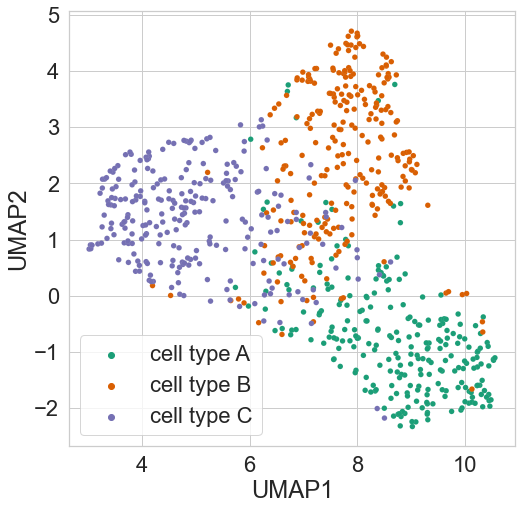

In [25]:
seed_base = 2
ATAC_count = tfidf2(ATAC_matrix5.T).T
ATAC_count_filter = ATAC_count
ATAC_count_filter = PCA(n_components=10,random_state=int(seed_base*1000)).fit_transform(ATAC_count_filter)
print('After PCA, the matrix dimensions are reduced to {}'.format(ATAC_count_filter.shape))
ATAC_pca = sc.AnnData(scipy.sparse.csc_matrix(ATAC_count_filter),dtype = 'float32')
ATAC_pca.obs['label'] = ['cell type A'] * 250 + ['cell type B'] * 250 + ['cell type C'] * 250
print(ATAC_pca.obs['label'])

# umap
label = ATAC_pca.obs['label']
proj = umap.UMAP().fit_transform(ATAC_count_filter)
fig = plt.figure()
fig.set_figwidth(8)
fig.set_figheight(8)
df = {'UMAP1':proj[:, 0],\
    'UMAP2':proj[:, 1], \
    'label':label}
df = pd.DataFrame(df)
ax = sns.scatterplot(x="UMAP1", y="UMAP2", hue="label",palette = 'Dark2', s=30,linewidth = 0.05, data=df)
# plt.savefig('sim5UMAP.pdf', bbox_inches ="tight", dpi=500)
ax.legend()
plt.show

# Evaluation

## Cofea

In [28]:
# dataset S1
ATAC_all = sc.AnnData(scipy.sparse.csc_matrix(ATAC_matrix1),dtype = 'float32')
ATAC_all.obs['label'] = label1
idx, ATAC_object, ATAC_count_filter = feature_selection(ATAC_all, 10000, 2, 0.01)
idx

AnnData object with n_obs × n_vars = 2000 × 100000
    obs: 'label'
Preselect peaks that are accessible in more than 1.0% of cells.
View of AnnData object with n_obs × n_vars = 2000 × 100000
    obs: 'label'
(100000, 100)
processing...0/100000 0%
processing...10000/100000 10%
processing...20000/100000 20%
processing...30000/100000 30%
processing...40000/100000 40%
processing...50000/100000 50%
processing...60000/100000 60%
processing...70000/100000 70%
processing...80000/100000 80%
processing...90000/100000 90%
processing...100000/100000 100%
First fitting.
Second fitting.
Third fitting.


array([64062, 43203, 22757, ...,  9177,  2250,  4928])

In [29]:
num = 10000
overlap1 = np.sum(idx < num) / num

overlap1_A = np.sum(idx < int(num/2)) / int(num/2)
overlap1_B = np.sum(np.bitwise_and((idx < num),(idx >= int(num/2)))) / int(num/2)
overlap1, overlap1_A, overlap1_B

(0.7753, 0.7772, 0.7734)

In [30]:
# dataset S2
ATAC_all = sc.AnnData(scipy.sparse.csc_matrix(ATAC_matrix2),dtype = 'float32')
ATAC_all.obs['label'] = label2
idx, ATAC_object, ATAC_count_filter = feature_selection(ATAC_all, 10000, 2, 0.01)
idx

AnnData object with n_obs × n_vars = 2000 × 99002
    obs: 'label'
Preselect peaks that are accessible in more than 1.0% of cells.
View of AnnData object with n_obs × n_vars = 2000 × 78990
    obs: 'label'
(78990, 100)
processing...0/78990 0%
processing...10000/78990 12%
processing...20000/78990 25%
processing...30000/78990 37%
processing...40000/78990 50%
processing...50000/78990 63%
processing...60000/78990 75%
processing...70000/78990 88%
processing...78990/78990 100%
First fitting.
Second fitting.
Third fitting.


array([36939, 30932, 60644, ..., 74882,  3178, 15591])

In [31]:
num = 10000
overlap2 = np.sum(idx < num) / num

overlap2_A = np.sum(idx < int(num/2)) / int(num/2)
overlap2_B = np.sum(np.bitwise_and((idx < num),(idx >= int(num/2)))) / int(num/2)
overlap2, overlap2_A, overlap2_B

(0.7229, 0.8906, 0.555)

In [37]:
# dataset S3
ATAC_all = sc.AnnData(scipy.sparse.csc_matrix(ATAC_matrix3),dtype = 'float32')
ATAC_all.obs['label'] = label3
idx, ATAC_object, ATAC_count_filter = feature_selection(ATAC_all, 15000, 2, 0.01)
idx

AnnData object with n_obs × n_vars = 3000 × 99404
    obs: 'label'
Preselect peaks that are accessible in more than 1.0% of cells.
View of AnnData object with n_obs × n_vars = 3000 × 82300
    obs: 'label'
(82300, 100)
processing...0/82300 0%
processing...10000/82300 12%
processing...20000/82300 24%
processing...30000/82300 36%
processing...40000/82300 48%
processing...50000/82300 60%
processing...60000/82300 72%
processing...70000/82300 85%
processing...80000/82300 97%
processing...82300/82300 100%
First fitting.
Second fitting.
Third fitting.


array([24413, 37733, 66109, ..., 11585, 10215, 11216])

In [38]:
num = 15000
overlap3 = np.sum(idx < num) / num

overlap3_A = np.sum(idx < 5000) / 5000
overlap3_B = np.sum(np.bitwise_and((idx < 10000),(idx >= 5000))) / 5000
overlap3_C = np.sum(np.bitwise_and((idx < 15000),(idx >= 10000))) / 5000
overlap3, overlap3_A, overlap3_B, overlap3_C

(0.9393333333333334, 0.966, 0.9234, 0.9282)

In [39]:
# dataset S4
ATAC_all = sc.AnnData(scipy.sparse.csc_matrix(ATAC_matrix4),dtype = 'float32')
ATAC_all.obs['label'] = label4
idx, ATAC_object, ATAC_count_filter = feature_selection(ATAC_all, 20000, 2, 0.01)
idx

AnnData object with n_obs × n_vars = 4000 × 99580
    obs: 'label'
Preselect peaks that are accessible in more than 1.0% of cells.
View of AnnData object with n_obs × n_vars = 4000 × 83502
    obs: 'label'
(83502, 100)
processing...0/83502 0%
processing...10000/83502 11%
processing...20000/83502 23%
processing...30000/83502 35%
processing...40000/83502 47%
processing...50000/83502 59%
processing...60000/83502 71%
processing...70000/83502 83%
processing...80000/83502 95%
processing...83502/83502 100%
First fitting.
Second fitting.
Third fitting.


array([82052, 36477, 77292, ..., 12714, 12030,  4582])

In [40]:
num = 20000
overlap4 = np.sum(idx < num) / num

overlap4_A = np.sum(idx < 5000) / 5000
overlap4_B = np.sum(np.bitwise_and((idx < 10000),(idx >= 5000))) / 5000
overlap4_C = np.sum(np.bitwise_and((idx < 15000),(idx >= 10000))) / 5000
overlap4_D = np.sum(np.bitwise_and((idx < 20000),(idx >= 15000))) / 5000
overlap4, overlap4_A, overlap4_B, overlap4_C, overlap4_D

(0.93005, 0.9764, 0.9718, 0.9698, 0.8018)

In [41]:
# dataset S5
ATAC_all = sc.AnnData(scipy.sparse.csc_matrix(ATAC_matrix5),dtype = 'float32')
ATAC_all.obs['label'] = label5
idx, ATAC_object, ATAC_count_filter = feature_selection(ATAC_all, 10000, 2, 0.01)
idx

AnnData object with n_obs × n_vars = 750 × 100000
    obs: 'label'
Preselect peaks that are accessible in more than 1.0% of cells.
View of AnnData object with n_obs × n_vars = 750 × 99999
    obs: 'label'
(99999, 100)
processing...0/99999 0%
processing...10000/99999 10%
processing...20000/99999 20%
processing...30000/99999 30%
processing...40000/99999 40%
processing...50000/99999 50%
processing...60000/99999 60%
processing...70000/99999 70%
processing...80000/99999 80%
processing...90000/99999 90%
processing...99999/99999 100%
First fitting.
Second fitting.
Third fitting.


array([52767, 37945, 81137, ..., 98107, 35948, 83982])

In [42]:
num = 10000
overlap5 = np.sum(idx < num) / num
overlap5

0.432

## HDA

In [45]:
# dataset S1
ATAC_all = sc.AnnData(scipy.sparse.csc_matrix(ATAC_matrix1),dtype = 'float32')
ATAC_all.obs['label'] = label1
idx, ATAC_object, ATAC_count_filter = HDA(ATAC_all, 10000, 0.01)
num = 10000
overlap1_HDA = np.sum(idx < num) / num

overlap1_A_HDA = np.sum(idx < int(num/2)) / int(num/2)
overlap1_B_HDA = np.sum(np.bitwise_and((idx < num),(idx >= int(num/2)))) / int(num/2)
overlap1_HDA, overlap1_A_HDA, overlap1_B_HDA

AnnData object with n_obs × n_vars = 2000 × 100000
    obs: 'label'
Preselect peaks that are accessible in more than 1.0% of cells.
View of AnnData object with n_obs × n_vars = 2000 × 100000
    obs: 'label'
(1, 100000)


(0.101, 0.099, 0.103)

In [46]:
# dataset S2
ATAC_all = sc.AnnData(scipy.sparse.csc_matrix(ATAC_matrix2),dtype = 'float32')
ATAC_all.obs['label'] = label2
idx, ATAC_object, ATAC_count_filter = HDA(ATAC_all, 10000, 0.01)
num = 10000
overlap2_HDA = np.sum(idx < num) / num

overlap2_A_HDA = np.sum(idx < int(num/2)) / int(num/2)
overlap2_B_HDA = np.sum(np.bitwise_and((idx < num),(idx >= int(num/2)))) / int(num/2)
overlap2_HDA, overlap2_A_HDA, overlap2_B_HDA

AnnData object with n_obs × n_vars = 2000 × 99002
    obs: 'label'
Preselect peaks that are accessible in more than 1.0% of cells.
View of AnnData object with n_obs × n_vars = 2000 × 78990
    obs: 'label'
(1, 78990)


(0.1252, 0.1236, 0.1266)

In [47]:
# dataset S3
ATAC_all = sc.AnnData(scipy.sparse.csc_matrix(ATAC_matrix3),dtype = 'float32')
ATAC_all.obs['label'] = label3
idx, ATAC_object, ATAC_count_filter = HDA(ATAC_all, 15000, 0.01)
num = 15000
overlap3_HDA = np.sum(idx < num) / num

overlap3_A_HDA = np.sum(idx < 5000) / 5000
overlap3_B_HDA = np.sum(np.bitwise_and((idx < 10000),(idx >= 5000))) / 5000
overlap3_C_HDA = np.sum(np.bitwise_and((idx < 15000),(idx >= 10000))) / 5000
overlap3_HDA, overlap3_A_HDA, overlap3_B_HDA, overlap3_C_HDA

AnnData object with n_obs × n_vars = 3000 × 99404
    obs: 'label'
Preselect peaks that are accessible in more than 1.0% of cells.
View of AnnData object with n_obs × n_vars = 3000 × 82300
    obs: 'label'
(1, 82300)


(0.2557333333333333, 0.7616, 0.002, 0.0036)

In [48]:
# dataset S4
ATAC_all = sc.AnnData(scipy.sparse.csc_matrix(ATAC_matrix4),dtype = 'float32')
ATAC_all.obs['label'] = label4
idx, ATAC_object, ATAC_count_filter = HDA(ATAC_all, 20000, 0.01)
num = 20000
overlap4_HDA = np.sum(idx < num) / num

overlap4_A_HDA = np.sum(idx < 5000) / 5000
overlap4_B_HDA = np.sum(np.bitwise_and((idx < 10000),(idx >= 5000))) / 5000
overlap4_C_HDA = np.sum(np.bitwise_and((idx < 15000),(idx >= 10000))) / 5000
overlap4_D_HDA = np.sum(np.bitwise_and((idx < 20000),(idx >= 15000))) / 5000
overlap4_HDA, overlap4_A_HDA, overlap4_B_HDA, overlap4_C_HDA, overlap4_D_HDA

AnnData object with n_obs × n_vars = 4000 × 99580
    obs: 'label'
Preselect peaks that are accessible in more than 1.0% of cells.
View of AnnData object with n_obs × n_vars = 4000 × 83502
    obs: 'label'
(1, 83502)


(0.1403, 0.1912, 0.1844, 0.1854, 0.0002)

In [49]:
# dataset S5
ATAC_all = sc.AnnData(scipy.sparse.csc_matrix(ATAC_matrix5),dtype = 'float32')
ATAC_all.obs['label'] = label5
idx, ATAC_object, ATAC_count_filter = HDA(ATAC_all, 10000, 0.01)
num = 10000
overlap5_HDA = np.sum(idx < num) / num
overlap5_HDA

AnnData object with n_obs × n_vars = 750 × 100000
    obs: 'label'
Preselect peaks that are accessible in more than 1.0% of cells.
View of AnnData object with n_obs × n_vars = 750 × 99999
    obs: 'label'
(1, 99999)


0.1039

## epiScanpy

AnnData object with n_obs × n_vars = 2000 × 100000
    obs: 'label'
Preselect peaks that are accessible in more than 1.0% of cells.
View of AnnData object with n_obs × n_vars = 2000 × 100000
    obs: 'label'


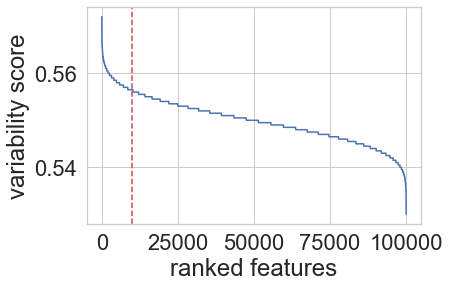

(0.101, 0.099, 0.103)

In [50]:
# dataset S1
ATAC_all = sc.AnnData(scipy.sparse.csc_matrix(ATAC_matrix1),dtype = 'float32')
ATAC_all.obs['label'] = label1
idx, ATAC_object, ATAC_count_filter = epiScanpy(ATAC_all, 10000, 0.01)
num = 10000
overlap1_epi = np.sum(idx < num) / num

overlap1_A_epi = np.sum(idx < int(num/2)) / int(num/2)
overlap1_B_epi = np.sum(np.bitwise_and((idx < num),(idx >= int(num/2)))) / int(num/2)
overlap1_epi, overlap1_A_epi, overlap1_B_epi

AnnData object with n_obs × n_vars = 2000 × 99002
    obs: 'label'
Preselect peaks that are accessible in more than 1.0% of cells.
View of AnnData object with n_obs × n_vars = 2000 × 78990
    obs: 'label'


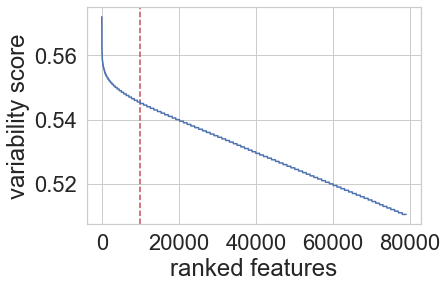

(0.1252, 0.1236, 0.1266)

In [51]:
# dataset S2
ATAC_all = sc.AnnData(scipy.sparse.csc_matrix(ATAC_matrix2),dtype = 'float32')
ATAC_all.obs['label'] = label2
idx, ATAC_object, ATAC_count_filter = epiScanpy(ATAC_all, 10000, 0.01)
num = 10000
overlap2_epi = np.sum(idx < num) / num

overlap2_A_epi = np.sum(idx < int(num/2)) / int(num/2)
overlap2_B_epi = np.sum(np.bitwise_and((idx < num),(idx >= int(num/2)))) / int(num/2)
overlap2_epi, overlap2_A_epi, overlap2_B_epi

AnnData object with n_obs × n_vars = 3000 × 99404
    obs: 'label'
Preselect peaks that are accessible in more than 1.0% of cells.
View of AnnData object with n_obs × n_vars = 3000 × 82300
    obs: 'label'


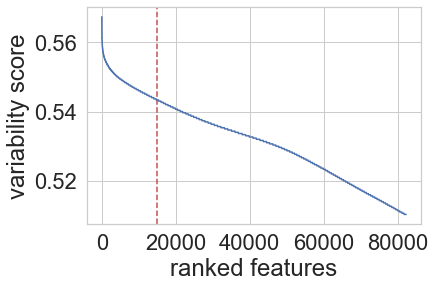

(0.2557333333333333, 0.7616, 0.002, 0.0036)

In [52]:
# dataset S3
ATAC_all = sc.AnnData(scipy.sparse.csc_matrix(ATAC_matrix3),dtype = 'float32')
ATAC_all.obs['label'] = label3
idx, ATAC_object, ATAC_count_filter = epiScanpy(ATAC_all, 15000, 0.01)
num = 15000
overlap3_epi = np.sum(idx < num) / num

overlap3_A_epi = np.sum(idx < 5000) / 5000
overlap3_B_epi = np.sum(np.bitwise_and((idx < 10000),(idx >= 5000))) / 5000
overlap3_C_epi = np.sum(np.bitwise_and((idx < 15000),(idx >= 10000))) / 5000
overlap3_epi, overlap3_A_epi, overlap3_B_epi, overlap3_C_epi

AnnData object with n_obs × n_vars = 4000 × 99580
    obs: 'label'
Preselect peaks that are accessible in more than 1.0% of cells.
View of AnnData object with n_obs × n_vars = 4000 × 83502
    obs: 'label'


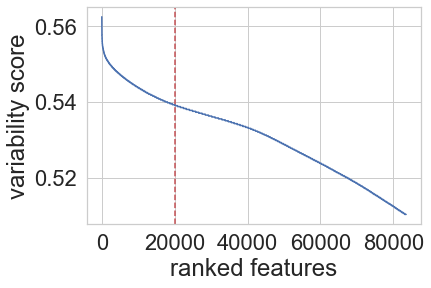

(0.1403, 0.1912, 0.1844, 0.1854, 0.0002)

In [53]:
# dataset S4
ATAC_all = sc.AnnData(scipy.sparse.csc_matrix(ATAC_matrix4),dtype = 'float32')
ATAC_all.obs['label'] = label4
idx, ATAC_object, ATAC_count_filter = epiScanpy(ATAC_all, 20000, 0.01)
num = 20000
overlap4_epi = np.sum(idx < num) / num

overlap4_A_epi = np.sum(idx < 5000) / 5000
overlap4_B_epi = np.sum(np.bitwise_and((idx < 10000),(idx >= 5000))) / 5000
overlap4_C_epi = np.sum(np.bitwise_and((idx < 15000),(idx >= 10000))) / 5000
overlap4_D_epi = np.sum(np.bitwise_and((idx < 20000),(idx >= 15000))) / 5000
overlap4_epi, overlap4_A_epi, overlap4_B_epi, overlap4_C_epi, overlap4_D_epi

AnnData object with n_obs × n_vars = 750 × 100000
    obs: 'label'
Preselect peaks that are accessible in more than 1.0% of cells.
View of AnnData object with n_obs × n_vars = 750 × 99999
    obs: 'label'


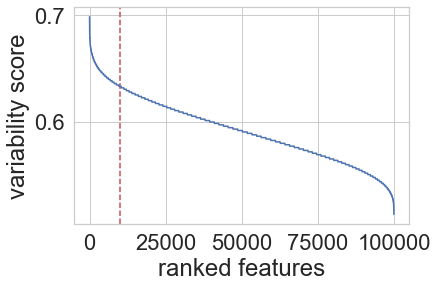

0.1039

In [54]:
# dataset S5
ATAC_all = sc.AnnData(scipy.sparse.csc_matrix(ATAC_matrix5),dtype = 'float32')
ATAC_all.obs['label'] = label5
idx, ATAC_object, ATAC_count_filter = epiScanpy(ATAC_all, 10000, 0.01)
num = 10000
overlap5_epi = np.sum(idx < num) / num
overlap5_epi

## Signac

In [55]:
# dataset S1
ATAC_all = sc.AnnData(scipy.sparse.csc_matrix(ATAC_matrix1),dtype = 'float32')
ATAC_all.obs['label'] = label1
idx, ATAC_object, ATAC_count_filter = Signac(ATAC_all, 10000, 0.01)
num = 10000
overlap1_sig = np.sum(idx < num) / num

overlap1_A_sig = np.sum(idx < int(num/2)) / int(num/2)
overlap1_B_sig = np.sum(np.bitwise_and((idx < num),(idx >= int(num/2)))) / int(num/2)
overlap1_sig, overlap1_A_sig, overlap1_B_sig

AnnData object with n_obs × n_vars = 2000 × 100000
    obs: 'label'
Preselect peaks that are accessible in more than 1.0% of cells.
View of AnnData object with n_obs × n_vars = 2000 × 100000
    obs: 'label'
(100000,)
0.90001


(0.1012, 0.0998, 0.1026)

In [56]:
# dataset S2
ATAC_all = sc.AnnData(scipy.sparse.csc_matrix(ATAC_matrix2),dtype = 'float32')
ATAC_all.obs['label'] = label2
idx, ATAC_object, ATAC_count_filter = Signac(ATAC_all, 10000, 0.01)
num = 10000
overlap2_sig = np.sum(idx < num) / num

overlap2_A_sig = np.sum(idx < int(num/2)) / int(num/2)
overlap2_B_sig = np.sum(np.bitwise_and((idx < num),(idx >= int(num/2)))) / int(num/2)
overlap2_sig, overlap2_A_sig, overlap2_B_sig

AnnData object with n_obs × n_vars = 2000 × 99002
    obs: 'label'
Preselect peaks that are accessible in more than 1.0% of cells.
View of AnnData object with n_obs × n_vars = 2000 × 78990
    obs: 'label'
(78990,)
0.8734143562476263


(0.1253, 0.1236, 0.1268)

In [57]:
# dataset S3
ATAC_all = sc.AnnData(scipy.sparse.csc_matrix(ATAC_matrix3),dtype = 'float32')
ATAC_all.obs['label'] = label3
idx, ATAC_object, ATAC_count_filter = Signac(ATAC_all, 15000, 0.01)
num = 15000
overlap3_sig = np.sum(idx < num) / num

overlap3_A_sig = np.sum(idx < 5000) / 5000
overlap3_B_sig = np.sum(np.bitwise_and((idx < 10000),(idx >= 5000))) / 5000
overlap3_C_sig = np.sum(np.bitwise_and((idx < 15000),(idx >= 10000))) / 5000
overlap3_sig, overlap3_A_sig, overlap3_B_sig, overlap3_C_sig

AnnData object with n_obs × n_vars = 3000 × 99404
    obs: 'label'
Preselect peaks that are accessible in more than 1.0% of cells.
View of AnnData object with n_obs × n_vars = 3000 × 82300
    obs: 'label'
(82300,)
0.8177521263669502


(0.25566666666666665, 0.7618, 0.0022, 0.003)

In [58]:
# dataset S4
ATAC_all = sc.AnnData(scipy.sparse.csc_matrix(ATAC_matrix4),dtype = 'float32')
ATAC_all.obs['label'] = label4
idx, ATAC_object, ATAC_count_filter = Signac(ATAC_all, 20000, 0.01)
num = 20000
overlap4_sig = np.sum(idx < num) / num

overlap4_A_sig = np.sum(idx < 5000) / 5000
overlap4_B_sig = np.sum(np.bitwise_and((idx < 10000),(idx >= 5000))) / 5000
overlap4_C_sig = np.sum(np.bitwise_and((idx < 15000),(idx >= 10000))) / 5000
overlap4_D_sig = np.sum(np.bitwise_and((idx < 20000),(idx >= 15000))) / 5000
overlap4_sig, overlap4_A_sig, overlap4_B_sig, overlap4_C_sig, overlap4_D_sig

AnnData object with n_obs × n_vars = 4000 × 99580
    obs: 'label'
Preselect peaks that are accessible in more than 1.0% of cells.
View of AnnData object with n_obs × n_vars = 4000 × 83502
    obs: 'label'
(83502,)
0.7604967545687529


(0.14015, 0.191, 0.184, 0.1854, 0.0002)

In [59]:
# dataset S5
ATAC_all = sc.AnnData(scipy.sparse.csc_matrix(ATAC_matrix5),dtype = 'float32')
ATAC_all.obs['label'] = label5
idx, ATAC_object, ATAC_count_filter = Signac(ATAC_all, 10000, 0.01)
num = 10000
overlap5_sig = np.sum(idx < num) / num
overlap5_sig

AnnData object with n_obs × n_vars = 750 × 100000
    obs: 'label'
Preselect peaks that are accessible in more than 1.0% of cells.
View of AnnData object with n_obs × n_vars = 750 × 99999
    obs: 'label'
(99999,)
0.9000090000900008


0.1019

## Plot

<AxesSubplot:xlabel='cell type', ylabel='overlap'>

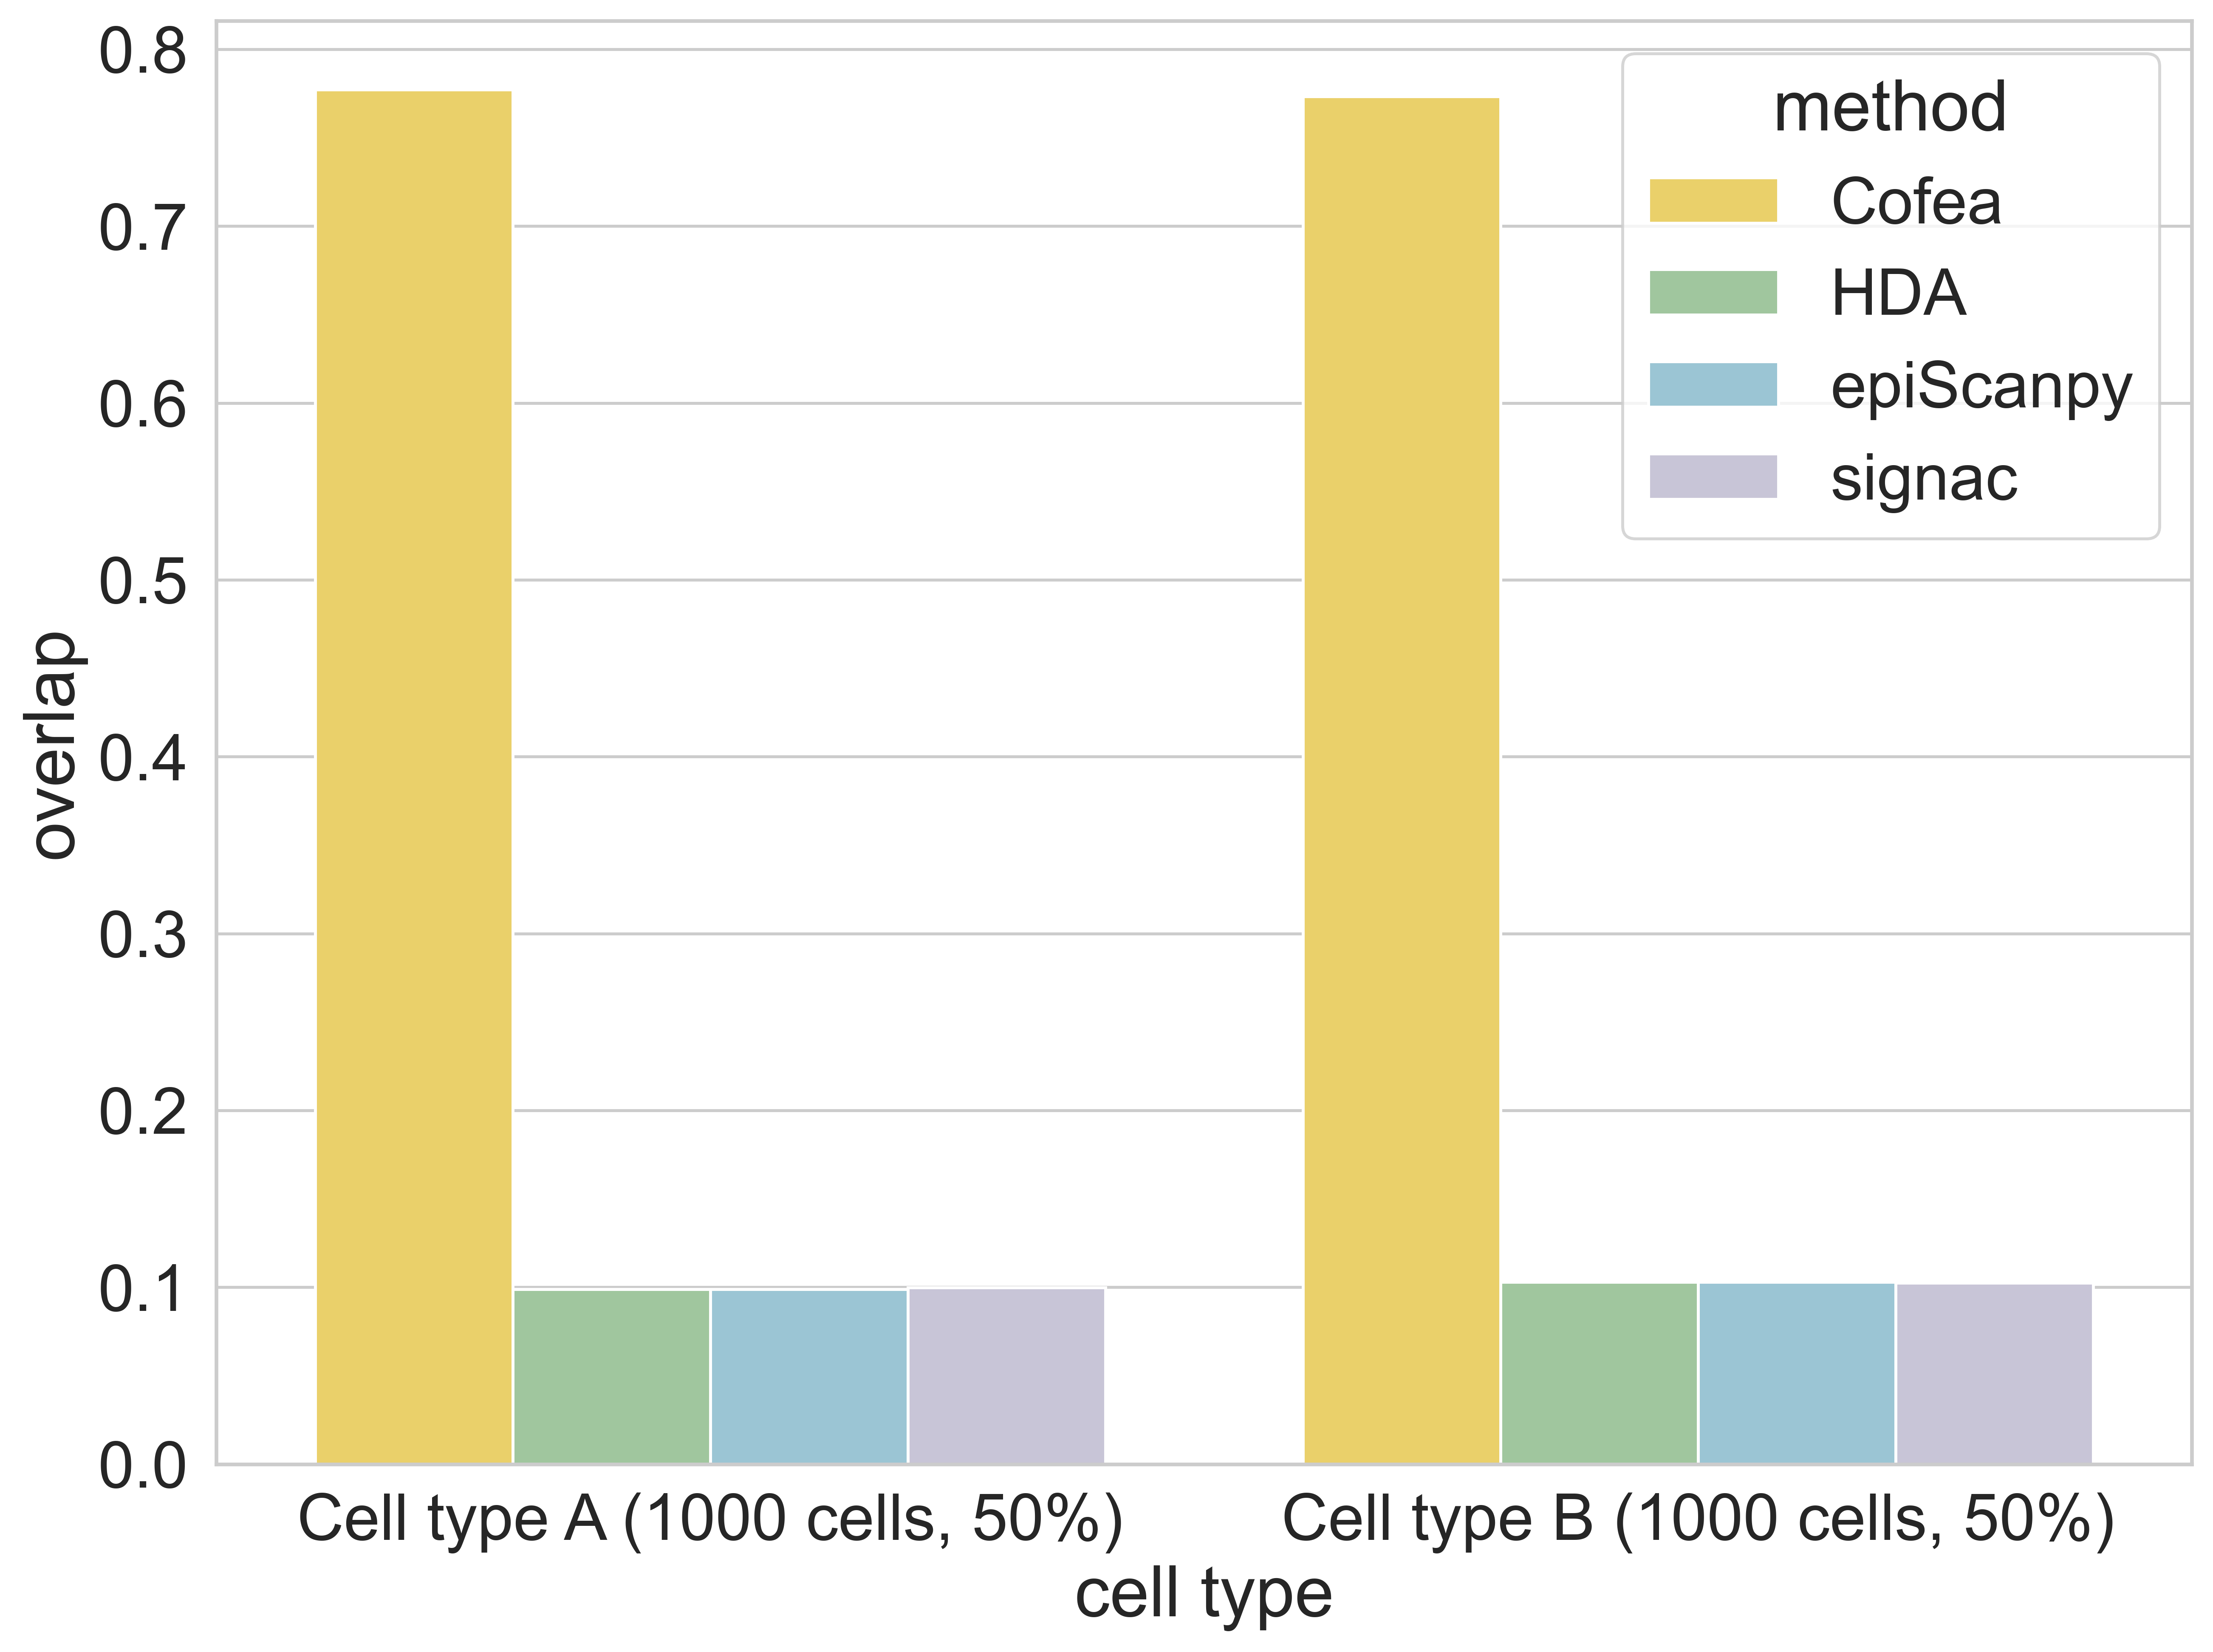

In [64]:
Cofea_overlap = []
HDA_overlap = []
epiScanpy_overlap = []
Signac_overlap = []

Cofea_overlap.append([overlap1_A, overlap1_B])
HDA_overlap.append([overlap1_A_HDA, overlap1_B_HDA])
epiScanpy_overlap.append([overlap1_A_epi, overlap1_B_epi])
Signac_overlap.append([overlap1_A_sig, overlap1_B_sig])

Cofea_overlap = np.array(Cofea_overlap)
HDA_overlap = np.array(HDA_overlap)
epiScanpy_overlap = np.array(epiScanpy_overlap)
Signac_overlap = np.array(Signac_overlap)

data1 = pd.DataFrame({'Cofea':Cofea_overlap[:,0], 'HDA':HDA_overlap[:,0], 'epiScanpy':epiScanpy_overlap[:,0], 'Signac':Signac_overlap[:,0]})
data2 = pd.DataFrame({'Cofea':Cofea_overlap[:,1], 'HDA':HDA_overlap[:,1], 'epiScanpy':epiScanpy_overlap[:,1], 'Signac':Signac_overlap[:,1]})

a = np.append(data1.values.reshape(-1),data2.values.reshape(-1))
b = ['Cofea', 'HDA', 'epiScanpy', 'signac'] * 2
c = ['Cell type A (1000 cells, 50%)'] * 4 + ['Cell type B (1000 cells, 50%)'] * 4

s1 = pd.DataFrame({'overlap':a, 'method':b, 'cell type':c})
plt.figure(figsize=(12,9), dpi=500)
sns.barplot(x="cell type", y="overlap", hue="method", data=s1,palette=["#FFDD55","#9ACD97","#92C9DD","#C6C2DA"])
# plt.savefig('/home/likeyi/program/method/result_final/sim4result.pdf', dpi=500)

<AxesSubplot:xlabel='cell type', ylabel='overlap'>

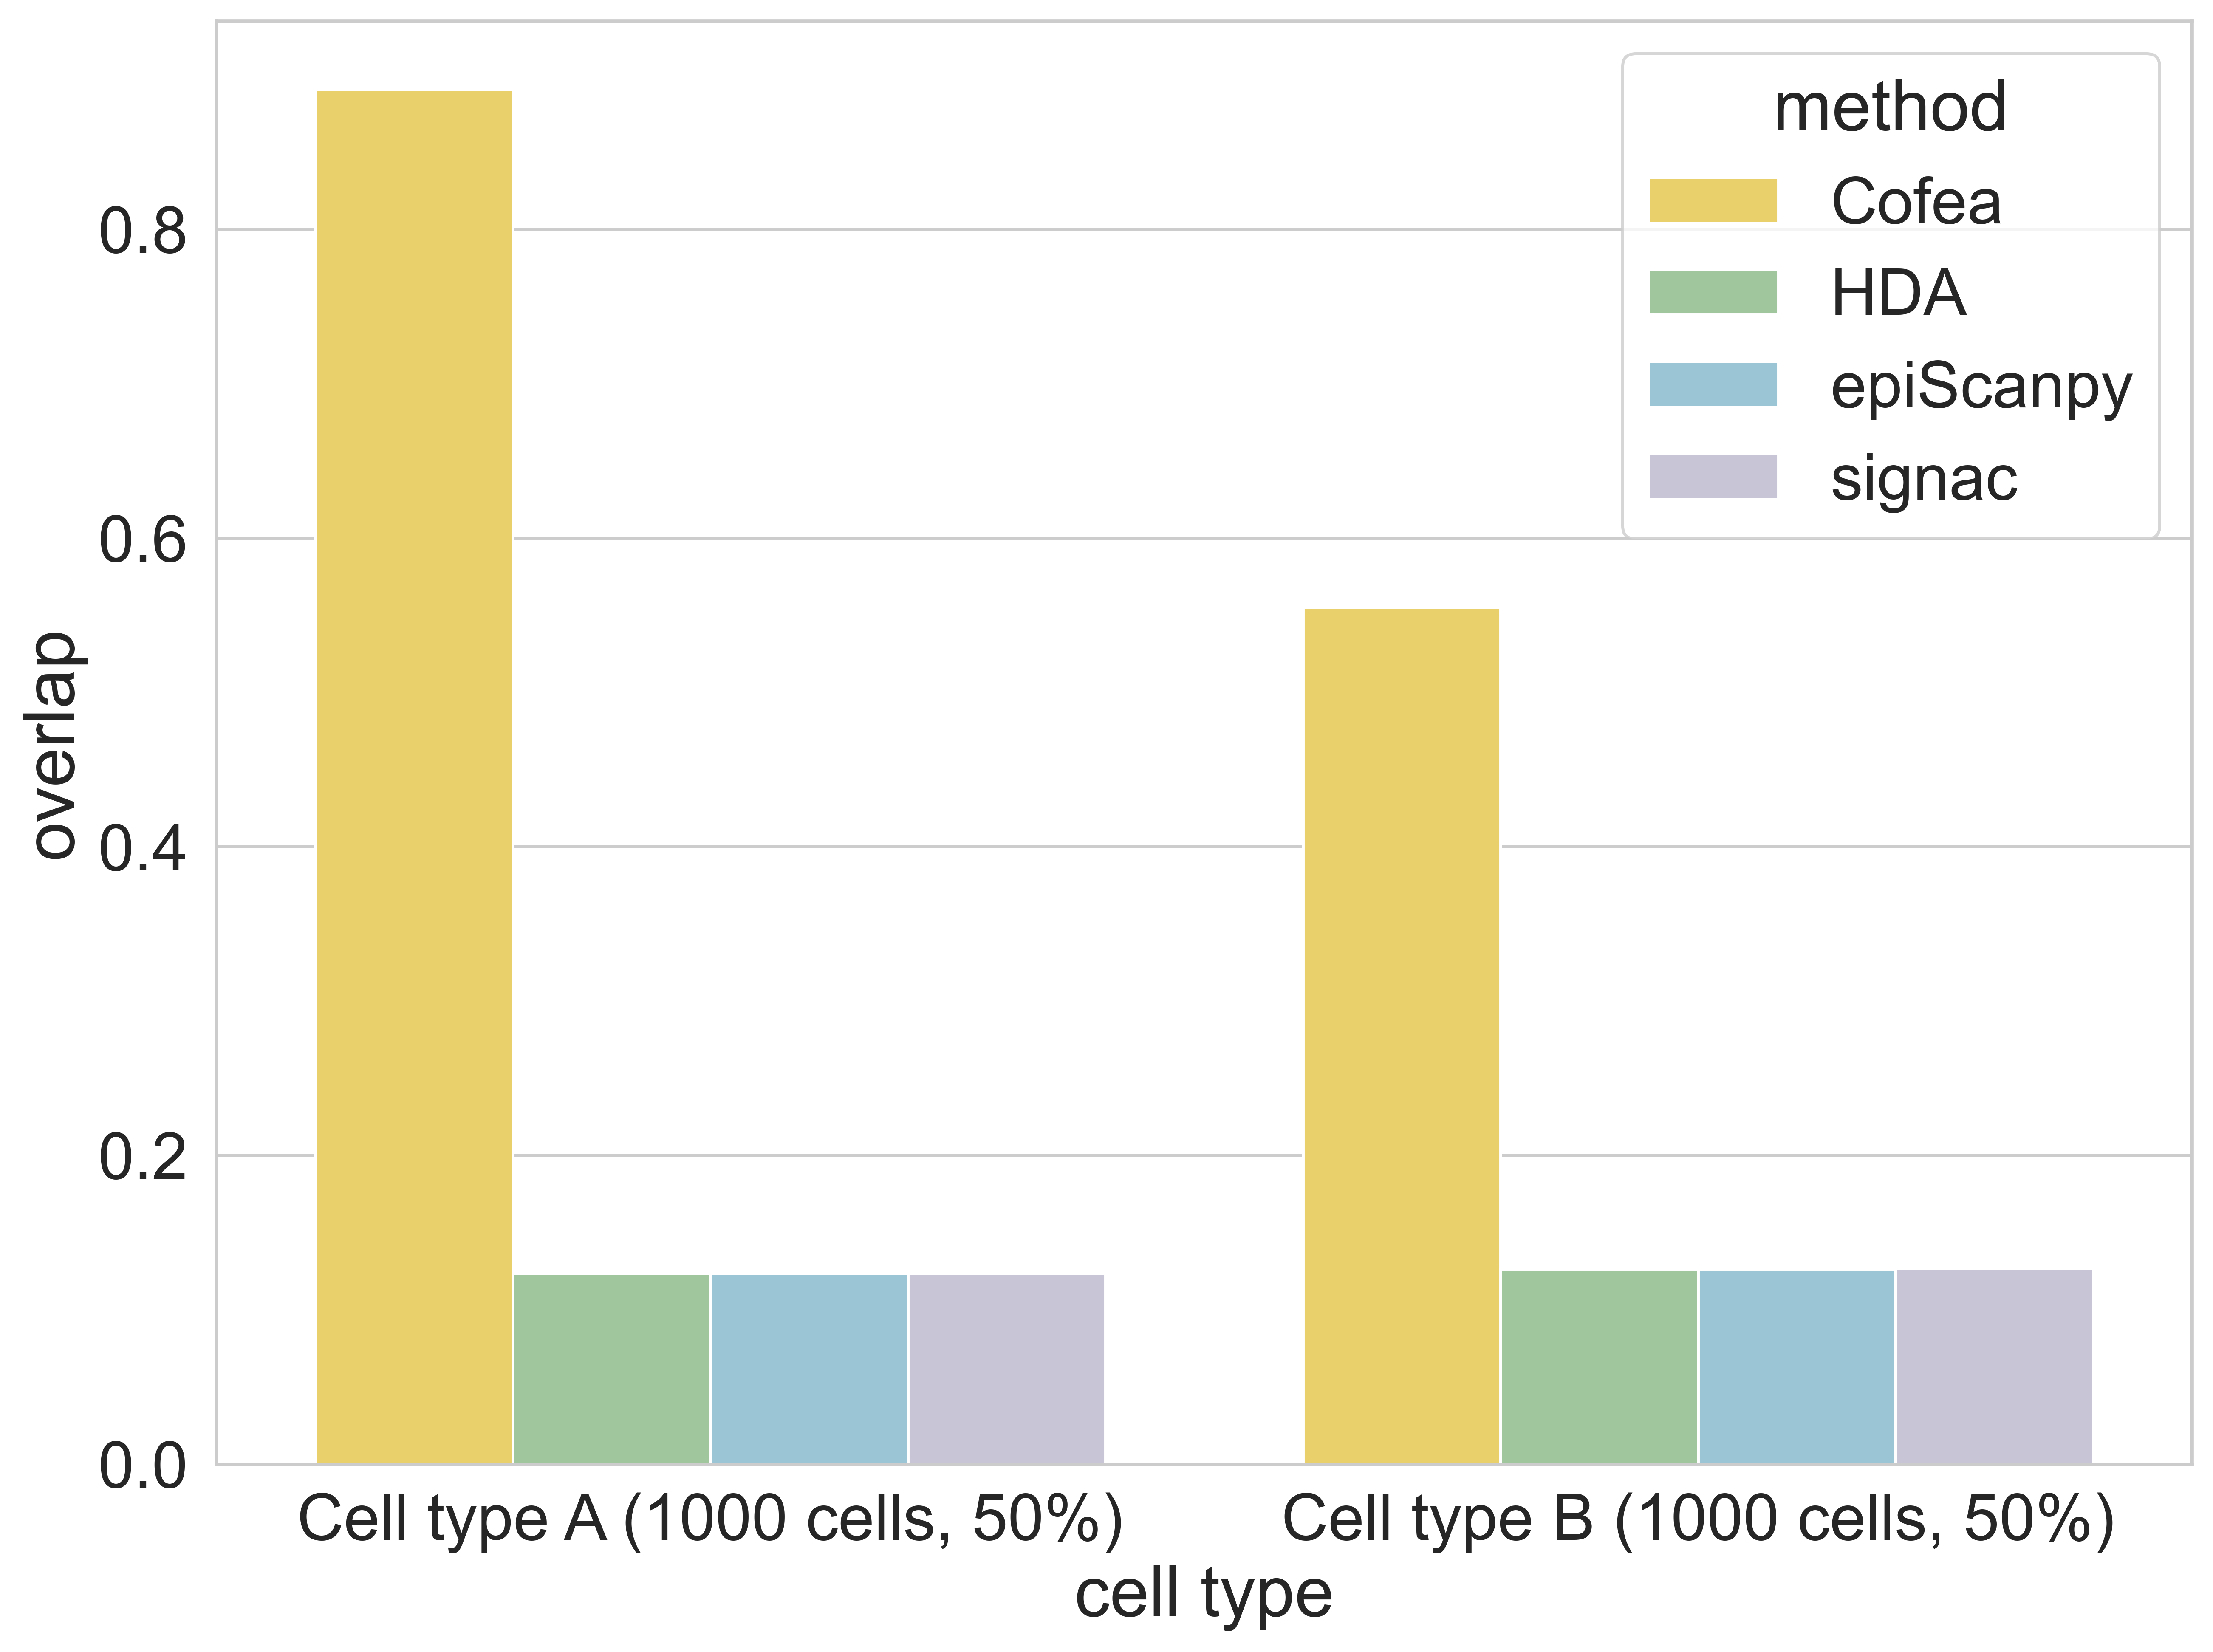

In [66]:
Cofea_overlap = []
HDA_overlap = []
epiScanpy_overlap = []
Signac_overlap = []

Cofea_overlap.append([overlap2_A, overlap2_B])
HDA_overlap.append([overlap2_A_HDA, overlap2_B_HDA])
epiScanpy_overlap.append([overlap2_A_epi, overlap2_B_epi])
Signac_overlap.append([overlap2_A_sig, overlap2_B_sig])

Cofea_overlap = np.array(Cofea_overlap)
HDA_overlap = np.array(HDA_overlap)
epiScanpy_overlap = np.array(epiScanpy_overlap)
Signac_overlap = np.array(Signac_overlap)

data1 = pd.DataFrame({'Cofea':Cofea_overlap[:,0], 'HDA':HDA_overlap[:,0], 'epiScanpy':epiScanpy_overlap[:,0], 'Signac':Signac_overlap[:,0]})
data2 = pd.DataFrame({'Cofea':Cofea_overlap[:,1], 'HDA':HDA_overlap[:,1], 'epiScanpy':epiScanpy_overlap[:,1], 'Signac':Signac_overlap[:,1]})

a = np.append(data1.values.reshape(-1),data2.values.reshape(-1))
b = ['Cofea', 'HDA', 'epiScanpy', 'signac'] * 2
c = ['Cell type A (1000 cells, 50%)'] * 4 + ['Cell type B (1000 cells, 50%)'] * 4

s2 = pd.DataFrame({'overlap':a, 'method':b, 'cell type':c})
plt.figure(figsize=(12,9), dpi=500)
sns.barplot(x="cell type", y="overlap", hue="method", data=s2,palette=["#FFDD55","#9ACD97","#92C9DD","#C6C2DA"])
# plt.savefig('/home/likeyi/program/method/result_final/sim4result.pdf', dpi=500)

<AxesSubplot:xlabel='cell type', ylabel='overlap'>

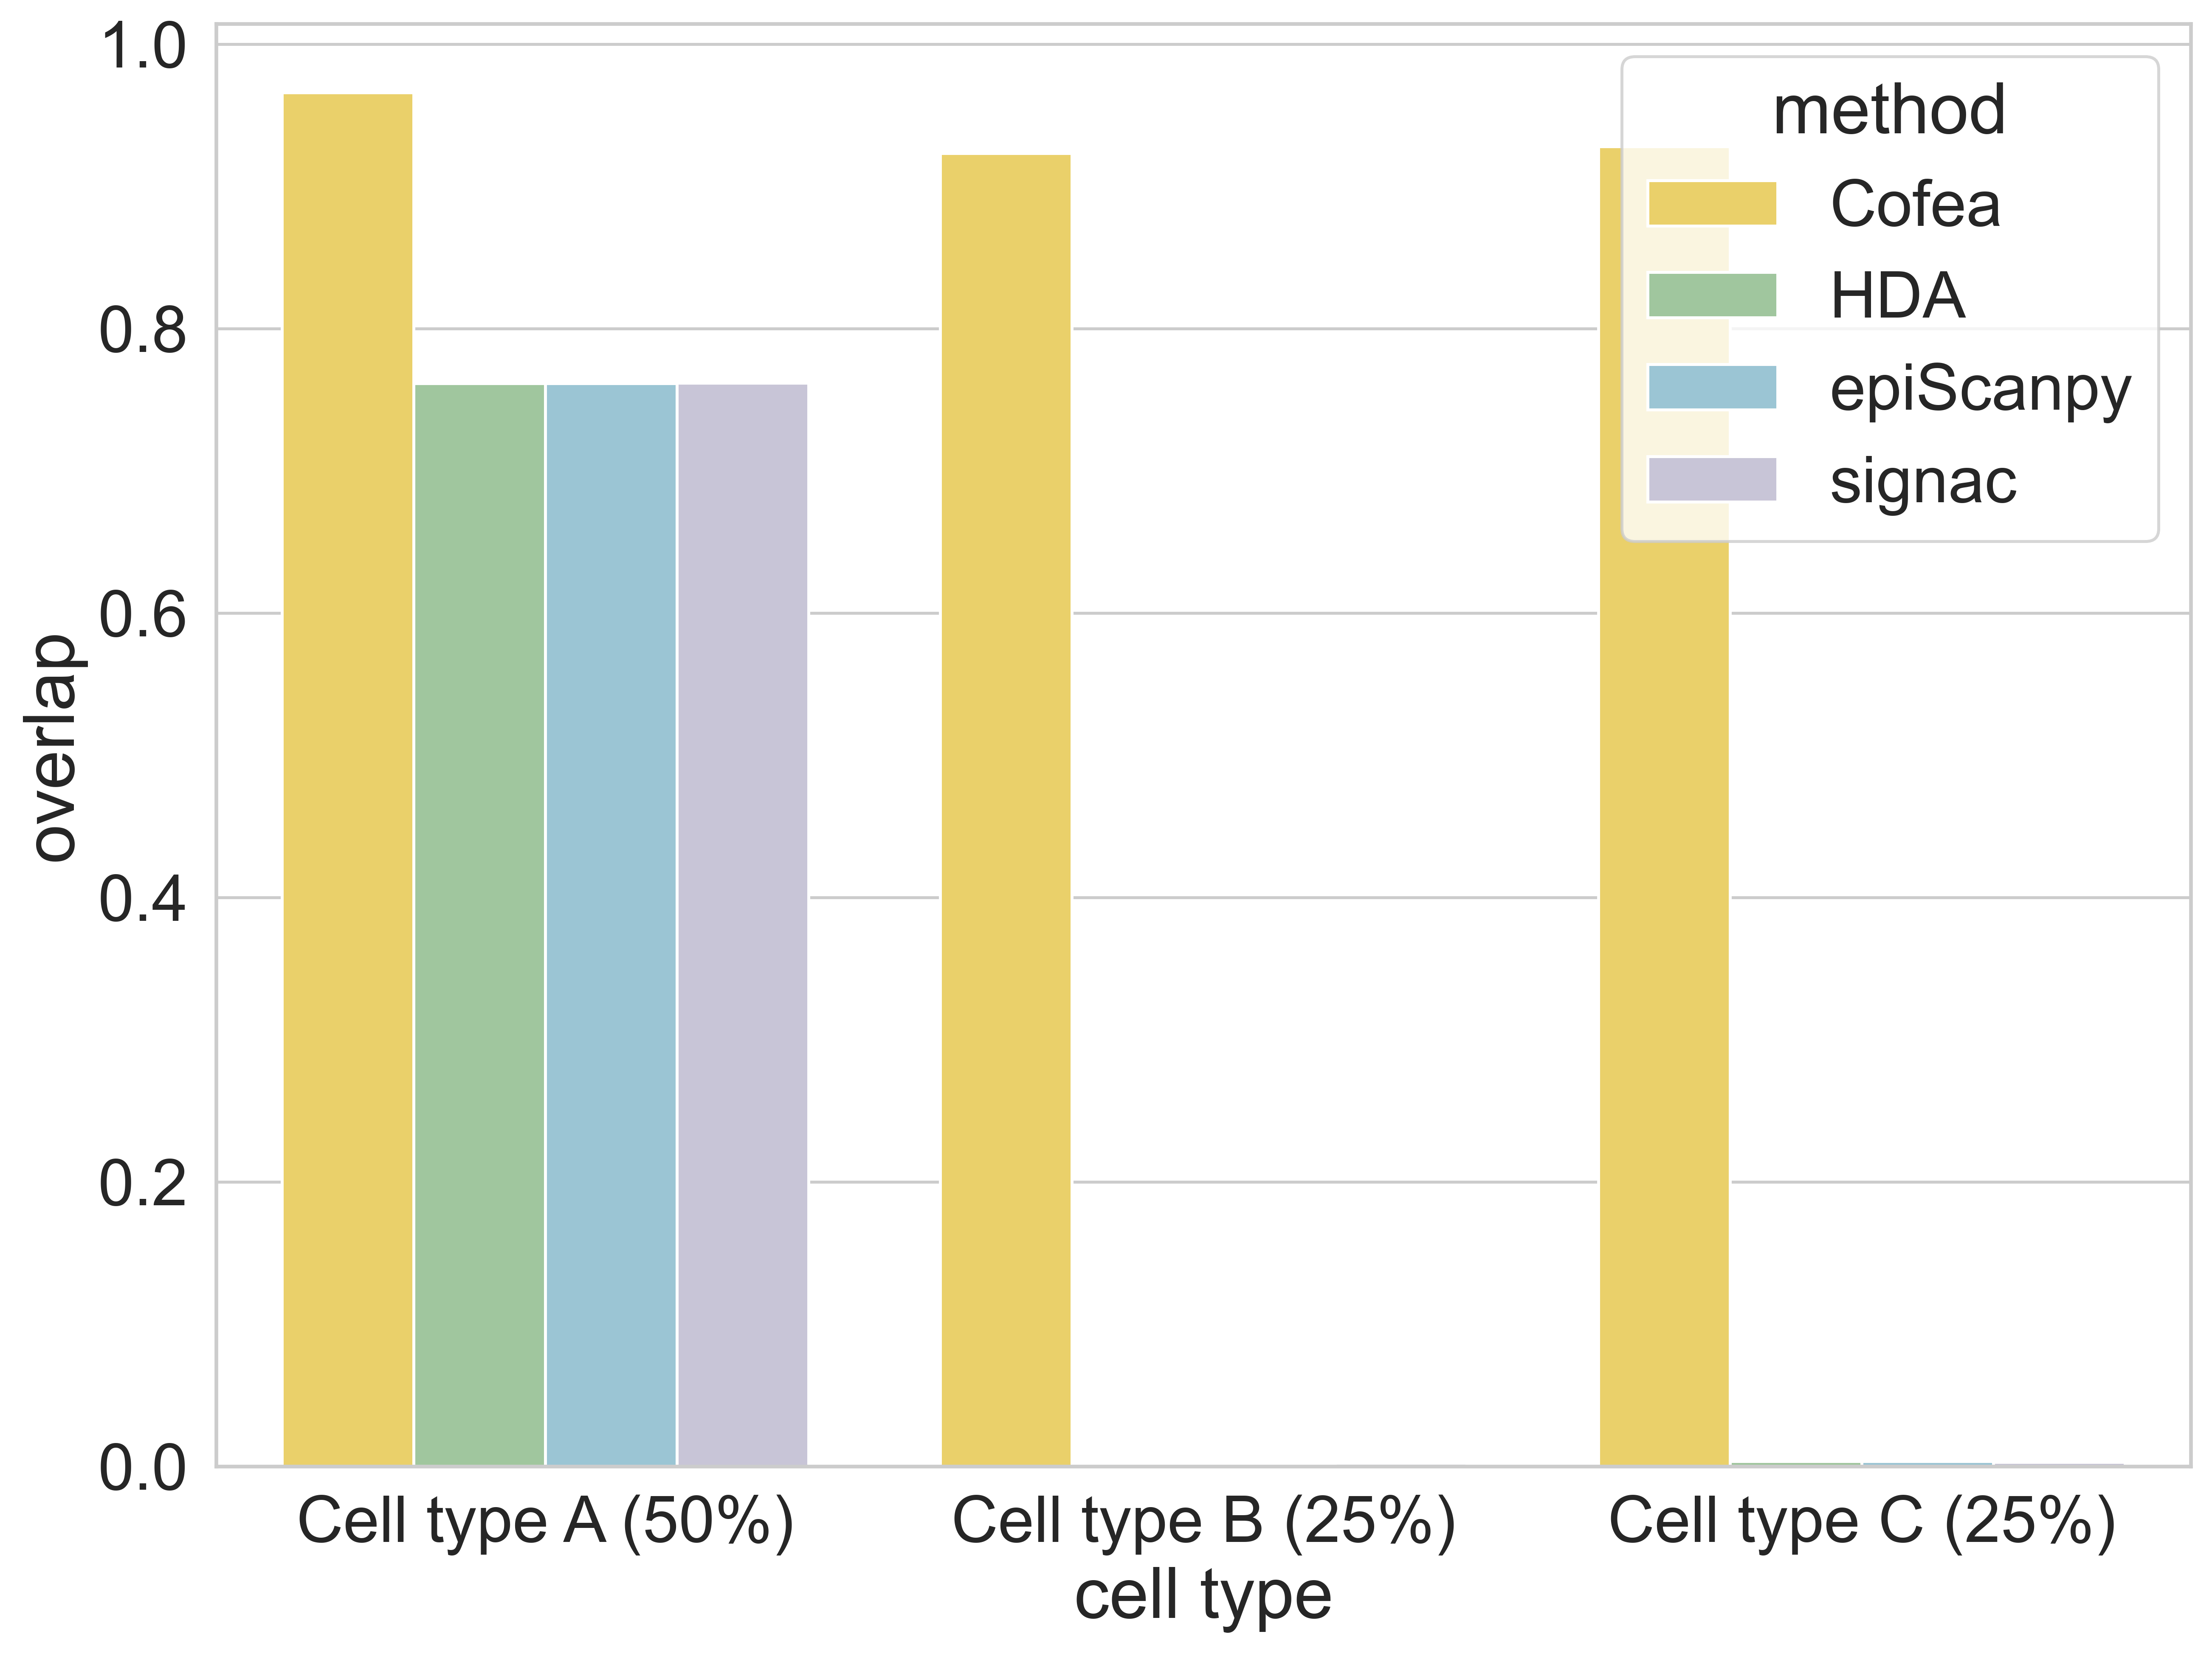

In [68]:
Cofea_overlap = []
HDA_overlap = []
epiScanpy_overlap = []
Signac_overlap = []

Cofea_overlap.append([overlap3_A, overlap3_B, overlap3_C])
HDA_overlap.append([overlap3_A_HDA, overlap3_B_HDA, overlap3_C_HDA])
epiScanpy_overlap.append([overlap3_A_epi, overlap3_B_epi, overlap3_C_epi])
Signac_overlap.append([overlap3_A_sig, overlap3_B_sig, overlap3_C_sig])

Cofea_overlap = np.array(Cofea_overlap)
HDA_overlap = np.array(HDA_overlap)
epiScanpy_overlap = np.array(epiScanpy_overlap)
Signac_overlap = np.array(Signac_overlap)

data1 = pd.DataFrame({'Cofea':Cofea_overlap[:,0], 'HDA':HDA_overlap[:,0], 'epiScanpy':epiScanpy_overlap[:,0], 'Signac':Signac_overlap[:,0]})
data2 = pd.DataFrame({'Cofea':Cofea_overlap[:,1], 'HDA':HDA_overlap[:,1], 'epiScanpy':epiScanpy_overlap[:,1], 'Signac':Signac_overlap[:,1]})
data3 = pd.DataFrame({'Cofea':Cofea_overlap[:,2], 'HDA':HDA_overlap[:,2], 'epiScanpy':epiScanpy_overlap[:,2], 'Signac':Signac_overlap[:,2]})

a = np.append(np.append(data1.values.reshape(-1),data2.values.reshape(-1)),data3.values.reshape(-1))
b = ['Cofea', 'HDA', 'epiScanpy', 'signac'] * 3
c = ['Cell type A (50%)'] * 4 + ['Cell type B (25%)'] * 4 + ['Cell type C (25%)'] * 4

s3 = pd.DataFrame({'overlap':a, 'method':b, 'cell type':c})
plt.figure(figsize=(12,9), dpi=500)
sns.barplot(x="cell type", y="overlap", hue="method", data=s3,palette=["#FFDD55","#9ACD97","#92C9DD","#C6C2DA"])

<AxesSubplot:xlabel='cell type', ylabel='overlap'>

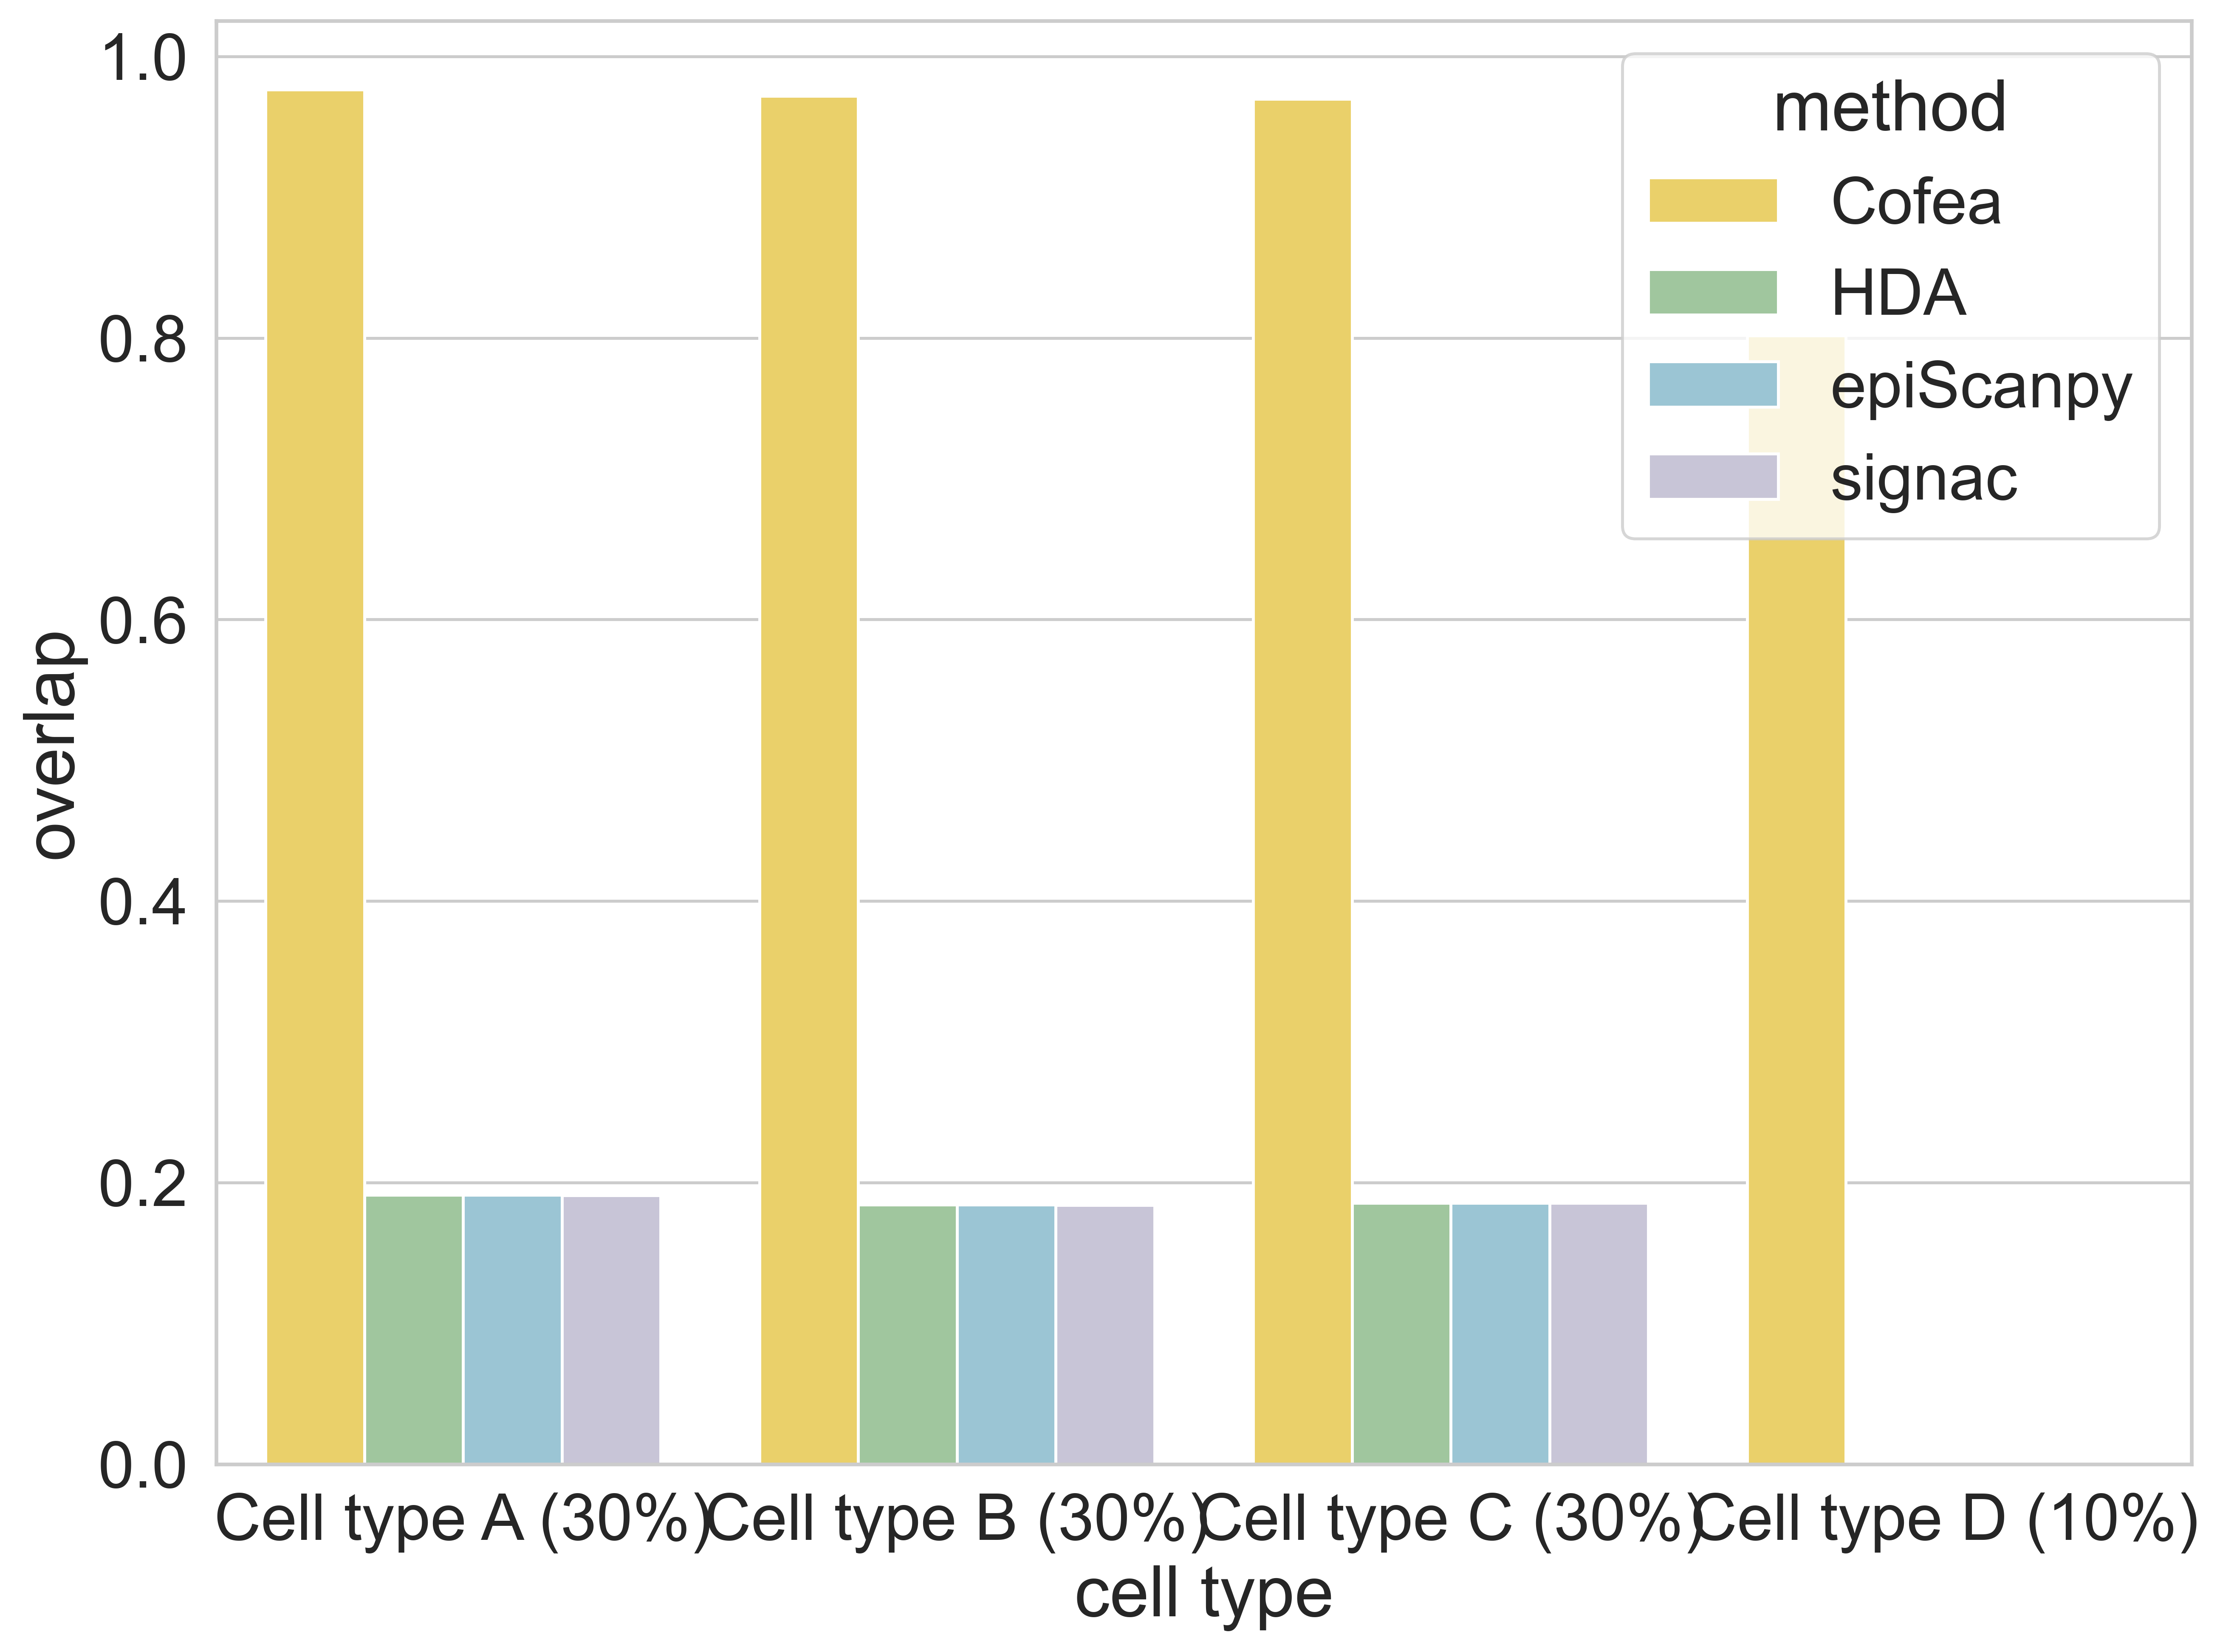

In [69]:
Cofea_overlap = []
HDA_overlap = []
epiScanpy_overlap = []
Signac_overlap = []

Cofea_overlap.append([overlap4_A, overlap4_B, overlap4_C, overlap4_D])
HDA_overlap.append([overlap4_A_HDA, overlap4_B_HDA, overlap4_C_HDA, overlap4_D_HDA])
epiScanpy_overlap.append([overlap4_A_epi, overlap4_B_epi, overlap4_C_epi, overlap4_D_epi])
Signac_overlap.append([overlap4_A_sig, overlap4_B_sig, overlap4_C_sig, overlap4_D_sig])

Cofea_overlap = np.array(Cofea_overlap)
HDA_overlap = np.array(HDA_overlap)
epiScanpy_overlap = np.array(epiScanpy_overlap)
Signac_overlap = np.array(Signac_overlap)

data1 = pd.DataFrame({'Cofea':Cofea_overlap[:,0], 'HDA':HDA_overlap[:,0], 'epiScanpy':epiScanpy_overlap[:,0], 'Signac':Signac_overlap[:,0]})
data2 = pd.DataFrame({'Cofea':Cofea_overlap[:,1], 'HDA':HDA_overlap[:,1], 'epiScanpy':epiScanpy_overlap[:,1], 'Signac':Signac_overlap[:,1]})
data3 = pd.DataFrame({'Cofea':Cofea_overlap[:,2], 'HDA':HDA_overlap[:,2], 'epiScanpy':epiScanpy_overlap[:,2], 'Signac':Signac_overlap[:,2]})
data4 = pd.DataFrame({'Cofea':Cofea_overlap[:,3], 'HDA':HDA_overlap[:,3], 'epiScanpy':epiScanpy_overlap[:,3], 'Signac':Signac_overlap[:,3]})

a = np.append(np.append(np.append(data1.values.reshape(-1),data2.values.reshape(-1)),data3.values.reshape(-1)),data4.values.reshape(-1))
b = ['Cofea', 'HDA', 'epiScanpy', 'signac'] * 4
c = ['Cell type A (30%)'] * 4 + ['Cell type B (30%)'] * 4 + ['Cell type C (30%)'] * 4 + ['Cell type D (10%)'] * 4

s4 = pd.DataFrame({'overlap':a, 'method':b, 'cell type':c})
plt.figure(figsize=(12,9), dpi=500)
sns.barplot(x="cell type", y="overlap", hue="method", data=s4,palette=["#FFDD55","#9ACD97","#92C9DD","#C6C2DA"])

<AxesSubplot:xlabel='cell type', ylabel='overlap'>

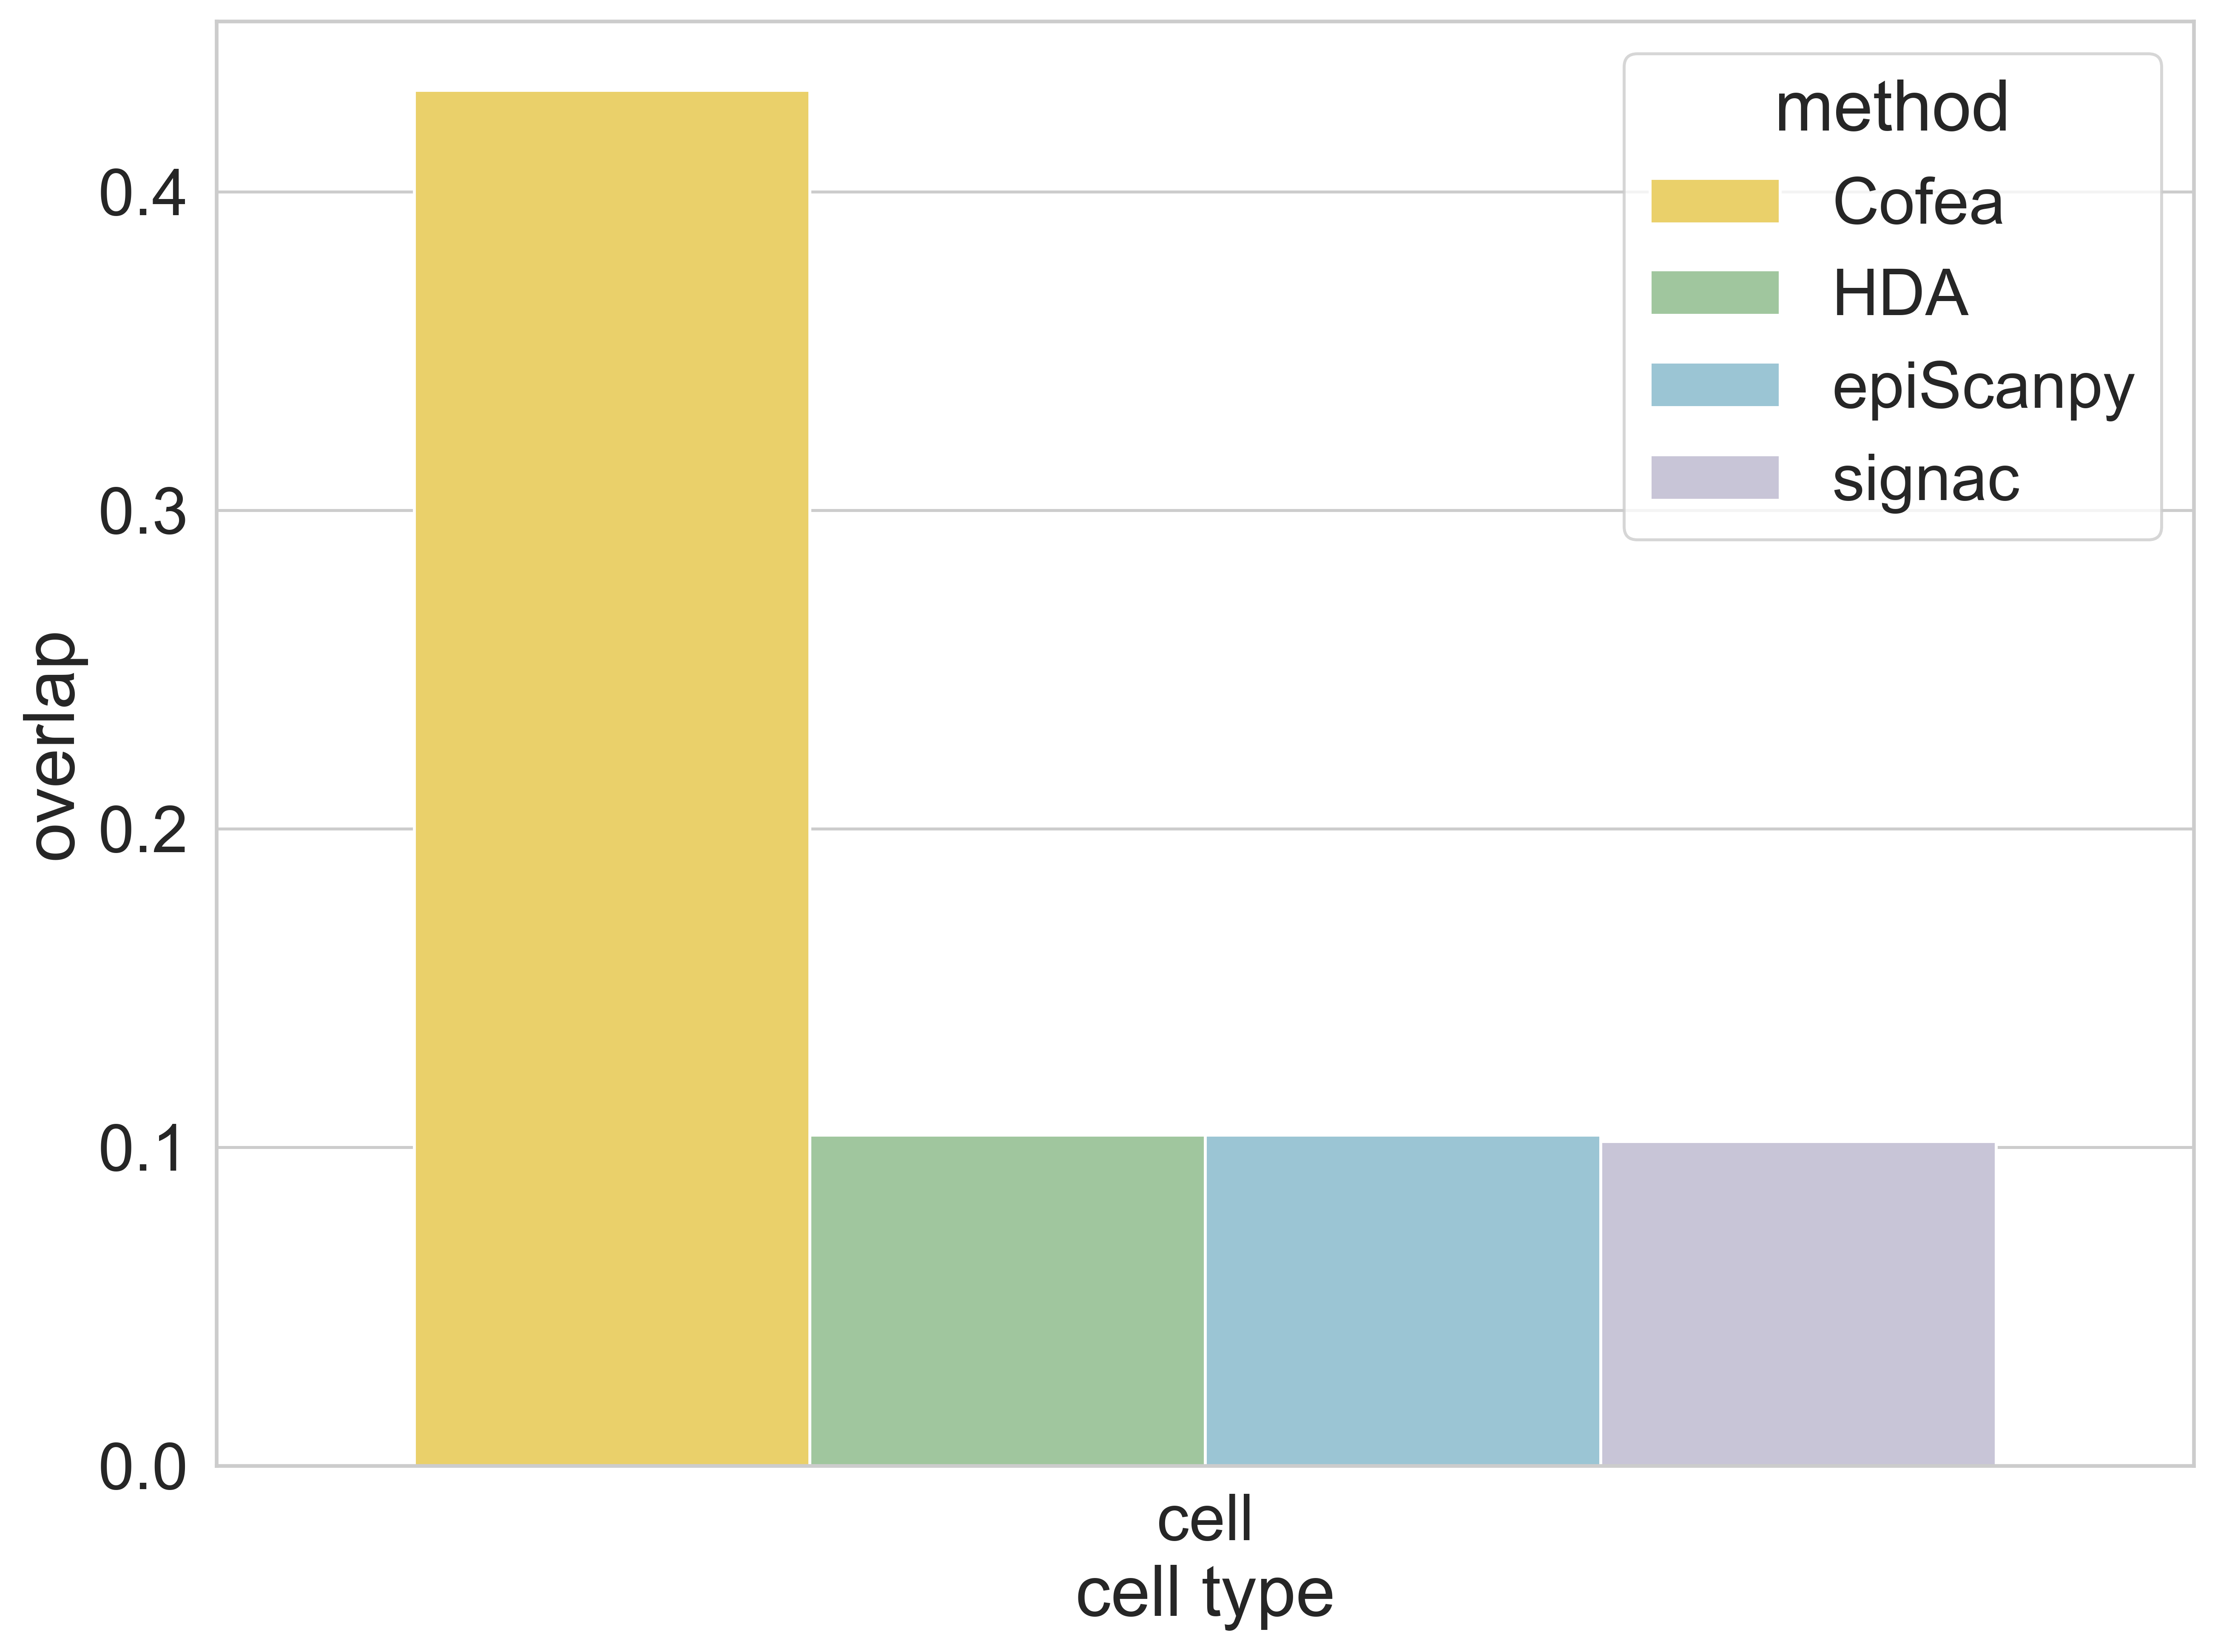

In [70]:
Cofea_overlap = []
HDA_overlap = []
epiScanpy_overlap = []
Signac_overlap = []

Cofea_overlap.append([overlap5])
HDA_overlap.append([overlap5_HDA])
epiScanpy_overlap.append([overlap5_epi])
Signac_overlap.append([overlap5_sig])

Cofea_overlap = np.array(Cofea_overlap)
HDA_overlap = np.array(HDA_overlap)
epiScanpy_overlap = np.array(epiScanpy_overlap)
Signac_overlap = np.array(Signac_overlap)

data1 = pd.DataFrame({'Cofea':Cofea_overlap[:,0], 'HDA':HDA_overlap[:,0], 'epiScanpy':epiScanpy_overlap[:,0], 'Signac':Signac_overlap[:,0]})

a = data1.values.reshape(-1)
b = ['Cofea', 'HDA', 'epiScanpy', 'signac']
c = ['cell'] * 4

s5 = pd.DataFrame({'overlap':a, 'method':b, 'cell type':c})
plt.figure(figsize=(12,9), dpi=500)
sns.barplot(x="cell type", y="overlap", hue="method", data=s5,palette=["#FFDD55","#9ACD97","#92C9DD","#C6C2DA"])